### Import all necessary libraries

In [6]:
import numpy as np
import random as rd
import cv2
import glob
from skimage import io
from matplotlib import pyplot as plt
import pandas as pd
import dill
from skimage.feature import hog

## Function HOG
We start by defining a HOG() function that computes the Histogram of Oriented Gradients of any 64x128 image.
The function takes as parameter the numpy array representing said image and returns a 3708 elements vector corresponding to the HOG of the function.

In [13]:
def HOG1(img):       
    # It is necessary here to start by normalizing the image
    img = np.float32(img) / 255.0     # All the values are between 0 and 1
    kernelX = np.array([[0, 0, 0],
                        [-1, 0, 1],    #Here we design two kernels,  
                        [0, 0, 0]])    # one to get the "horizontal" derivate of the gradient
    kernelY = np.array([[0, -1, 0],                        # (derivate with regard to X)
                        [0, 0, 0],     # And the other one to get the "vertical" derivate of the gradient
                        [0, 1, 0]])                                   # (derivate with regard to Y)
    tempX = cv2.filter2D(img, -1, kernelX) # We convolute the image with the two kernels 
    tempY = cv2.filter2D(img, -1, kernelY)    # And set the result in grayscale
    gX = cv2.cvtColor(tempX, cv2.COLOR_BGR2GRAY)  # Indeed the color information is not relevant for us
    gY = cv2.cvtColor(tempY, cv2.COLOR_BGR2GRAY)   # We get gX and gY the gradient image with regard to X and Y
    Norm, Angle = cv2.cartToPolar(gX, gY, angleInDegrees=True)
    # This function here allows, using gX and gY, to obtain the Norm and Angle of the gradient.
    # It exploits the formulas : Norm = sqrt(gX^2 + gY^2)  and Angle = atan(gY/gX)  (to apply to every pixel)
    for i in range(128):
        for j in range(64):              # The Angle matrix contains value between 0° and 360°
            if Angle[i, j] >= 180:       # Such a wide range of values is useless, therefore we reduce it here to 
                Angle[i, j] = Angle[i, j] - 180                 # values between 0° (included) and 180° (excluded)
    
    # We now have the orientation and norm values of the gradient for each pixel
    # The next step is to separate the image into 8x8 cells and compute an histogram of oriented gradients for each
    cellsHOG = np.array([[[0.0]*9]*8]*16)
    # We have 16 rows of 8 cells, and for each one the histogram can be represented as a 9-element vector
    # Each element corresponding to a discrete orientation of the gradient.
    discAngle = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160])
    # This vector represents the 9 discrete values for the orientation of the gradient.
    for j in range(0, 128, 8):
        for i in range(0, 64, 8):       # Here we are simply creating the 8x8 cells, for both Norm and Angle matrices
            cellNorm = Norm[j:j+8, i:i+8]
            cellAngle = Angle[j:j+8, i:i+8]
            hogCell = np.array([0.0]*9)   # For each cell we represent the histogram as a 9-element vector
            for x in range(8):
                for y in range(8): # (for each pixel in the cell and for each orientation value)
                    for k in range(1, 8):
                    # Each pixel's orientation value is between two discrete orientation values.
                    # We split the norm value of the gradient between each discrete orientation value,
                    # according to the distance between the 2 discrete values and the real one (the one of the pixel).
                    # For example, if the real orientation is 10° and the norm is 1, we will put 0.5 in the spot
                    # corresponding to 0° and 0.5 in the spot corresponding to 10°.
                        if (discAngle[k-1] <= cellAngle[x, y]) and (cellAngle[x, y] <= discAngle[k]) :
                            hogCell[k-1] = hogCell[k-1] + (cellAngle[x, y] - discAngle[k-1])*(cellNorm[x, y]/20)
                            hogCell[k] = hogCell[k] + (discAngle[k] - cellAngle[x, y])*(cellNorm[x, y]/20)
                    # The case where the angle is bigger than 160° is treated almost the same way:
                    # It means the angle is between 160° and 180° (180° being the max as we assured before)
                    # So we consider 180° as we would consider 0°, and split the norm value between the 160° spot
                    # and the 0° spot, according to the distances computed as before, using 180° instead of 0°.
                    if cellAngle[x, y] > discAngle[8]:
                        hogCell[8] = hogCell[8] + (cellAngle[x, y] - discAngle[8])*(cellNorm[x, y]/20)
                        hogCell[0] = hogCell[0] + (180 - cellAngle[x, y])*(cellNorm[x, y]/20)
            cellsHOG[j//8, i//8] = hogCell # hogCell represents the hog for the current cell
            #cellsHOG is a matrix that contains the HOG of each cell, sorted by position of the cell in the image
    
    # For the last step we need to design 16x16 overlapping blocks (each containing 2x2 cells)
    # (each cell is present in one block at least and four blocks at most)
    blocksNormalHOG = np.array([])
    for k in range(len(cellsHOG)-1):
        for h in range(len(cellsHOG[0])-1):   # Here we design those blocks
            vec = np.array([])
            for b in range(k, k+2):   # Each block has 4 cells, so it has four 9-element vectors representing a HOG.
                for c in range(h, h+2):  # We concatenate these 4 vectors for each block
                    vec = np.concatenate((vec, cellsHOG[b, c]))   # And we get a 36-element vector for each block.
            vec = vec/np.linalg.norm(vec) # We normalize all these 36-element vectors.
            blocksNormalHOG = np.concatenate((blocksNormalHOG, vec))
            # And then we just have to concatenate them.
            # We had 8x16 cells, which means (since we use overlapping blocks of 2x2 cells) that we have 7x15 blocks.
            # The final vector we are returning has then 7x15x36 = 3780 elements.
    
    return blocksNormalHOG

In [15]:
def HOG(image):
    return hog(image, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), block_norm='L2')

In [16]:
img1 = cv2.imread("Pedestrians/Patch_Video_Human.jpg")
print(HOG(img1))

[0.08300421 0.01338513 0.03604244 ... 0.11201072 0.15698541 0.        ]


## Saving the HOG() function
This function will be useful later, we might as well save it thanks to the pickle module

In [3]:
file = open('Saved\\HOG','wb')
dill.dump(HOG, file)
file.close()

## Creating the dataframe using the HOG() function
We will use here all the images from the training and test datasets, compute their HOG, labeling them -1 or 1 depending on if they contain humans or not (1 corresponding to the case where they contain a human), and put them in different dataframes.
We use -1 and not 0 as it will make things simplier when training the SVM classifier.

In [19]:
# We start by creating an empty training dataset
col = ["HOG_"+str(i) for i in range(3781)]
col[0] = "label"
train_data = pd.DataFrame(data=None, columns=col)

# Then we look at all the images containing humans in the training dataset
train_pos_mask = "Datasets\\Train\\Pos\\*.*"
train_pos_names = glob.glob(train_pos_mask)     # We use the same tool as during the pre-processing
for path in train_pos_names:
    print("processing %s..." % path,)
    img = cv2.imread(path)
    h = HOG(img)
    label = np.array([1]) # As they are all images not containing humans, we label them 1
    data_i = pd.Series(np.append(label, h), index=train_data.columns)
    train_data = train_data.append(data_i, ignore_index=True) # We add the computed data to the dataframe object
# Now we do the same thing for the images not containing humans in the training dataset
train_neg_mask = "Datasets\\Train\\Neg\\*.*"
train_neg_names = glob.glob(train_neg_mask)
for path in train_neg_names:
    print("processing %s..." % path,)
    img = cv2.imread(path)
    h = HOG(img)
    label = np.array([-1]) # As they are all images not containing humans, we label them -1
    data_i = pd.Series(np.append(label, h), index=train_data.columns)
    train_data = train_data.append(data_i, ignore_index=True)
train_data = train_data.sample(frac=1).reset_index(drop=True)  #We shuffle the dataframe and reset the index
# The shuffling is necessary because of the way we built this dataset (all the pos then all the neg)
train_data.to_csv("Datasets\\Train\\train_data_b2.csv")
# And we save this dataframe into a csv

processing Datasets\Train\Pos\crop001001a.jpg...
processing Datasets\Train\Pos\crop001001b.jpg...
processing Datasets\Train\Pos\crop001001c.jpg...
processing Datasets\Train\Pos\crop001001d.jpg...
processing Datasets\Train\Pos\crop001001e.jpg...
processing Datasets\Train\Pos\crop001001f.jpg...
processing Datasets\Train\Pos\crop001002a.jpg...
processing Datasets\Train\Pos\crop001002b.jpg...
processing Datasets\Train\Pos\crop001002c.jpg...
processing Datasets\Train\Pos\crop001002d.jpg...
processing Datasets\Train\Pos\crop001003a.jpg...
processing Datasets\Train\Pos\crop001003b.jpg...
processing Datasets\Train\Pos\crop001003c.jpg...
processing Datasets\Train\Pos\crop001003d.jpg...
processing Datasets\Train\Pos\crop001004a.jpg...
processing Datasets\Train\Pos\crop001004b.jpg...
processing Datasets\Train\Pos\crop001004c.jpg...
processing Datasets\Train\Pos\crop001004d.jpg...
processing Datasets\Train\Pos\crop001005a.jpg...
processing Datasets\Train\Pos\crop001005b.jpg...
processing Datasets\

processing Datasets\Train\Pos\crop001063b.jpg...
processing Datasets\Train\Pos\crop001063c.jpg...
processing Datasets\Train\Pos\crop001063d.jpg...
processing Datasets\Train\Pos\crop001063e.jpg...
processing Datasets\Train\Pos\crop001063f.jpg...
processing Datasets\Train\Pos\crop001063g.jpg...
processing Datasets\Train\Pos\crop001063h.jpg...
processing Datasets\Train\Pos\crop001064a.jpg...
processing Datasets\Train\Pos\crop001064b.jpg...
processing Datasets\Train\Pos\crop001064c.jpg...
processing Datasets\Train\Pos\crop001064d.jpg...
processing Datasets\Train\Pos\crop001064e.jpg...
processing Datasets\Train\Pos\crop001064f.jpg...
processing Datasets\Train\Pos\crop001064g.jpg...
processing Datasets\Train\Pos\crop001064h.jpg...
processing Datasets\Train\Pos\crop001066a.jpg...
processing Datasets\Train\Pos\crop001066b.jpg...
processing Datasets\Train\Pos\crop001068a.jpg...
processing Datasets\Train\Pos\crop001068b.jpg...
processing Datasets\Train\Pos\crop001069a.jpg...
processing Datasets\

processing Datasets\Train\Pos\crop001110c.jpg...
processing Datasets\Train\Pos\crop001110d.jpg...
processing Datasets\Train\Pos\crop001111a.jpg...
processing Datasets\Train\Pos\crop001111b.jpg...
processing Datasets\Train\Pos\crop001112a.jpg...
processing Datasets\Train\Pos\crop001112b.jpg...
processing Datasets\Train\Pos\crop001112c.jpg...
processing Datasets\Train\Pos\crop001112d.jpg...
processing Datasets\Train\Pos\crop001113a.jpg...
processing Datasets\Train\Pos\crop001113b.jpg...
processing Datasets\Train\Pos\crop001113c.jpg...
processing Datasets\Train\Pos\crop001113d.jpg...
processing Datasets\Train\Pos\crop001113e.jpg...
processing Datasets\Train\Pos\crop001113f.jpg...
processing Datasets\Train\Pos\crop001114a.jpg...
processing Datasets\Train\Pos\crop001114b.jpg...
processing Datasets\Train\Pos\crop001114c.jpg...
processing Datasets\Train\Pos\crop001114d.jpg...
processing Datasets\Train\Pos\crop001114e.jpg...
processing Datasets\Train\Pos\crop001114f.jpg...
processing Datasets\

processing Datasets\Train\Pos\crop001271a.jpg...
processing Datasets\Train\Pos\crop001271b.jpg...
processing Datasets\Train\Pos\crop001271c.jpg...
processing Datasets\Train\Pos\crop001271d.jpg...
processing Datasets\Train\Pos\crop001272a.jpg...
processing Datasets\Train\Pos\crop001272b.jpg...
processing Datasets\Train\Pos\crop001273a.jpg...
processing Datasets\Train\Pos\crop001273b.jpg...
processing Datasets\Train\Pos\crop001273c.jpg...
processing Datasets\Train\Pos\crop001273d.jpg...
processing Datasets\Train\Pos\crop001274a.jpg...
processing Datasets\Train\Pos\crop001274b.jpg...
processing Datasets\Train\Pos\crop001275a.jpg...
processing Datasets\Train\Pos\crop001275b.jpg...
processing Datasets\Train\Pos\crop001276a.jpg...
processing Datasets\Train\Pos\crop001276b.jpg...
processing Datasets\Train\Pos\crop001278a.jpg...
processing Datasets\Train\Pos\crop001278b.jpg...
processing Datasets\Train\Pos\crop001500a.jpg...
processing Datasets\Train\Pos\crop001500b.jpg...
processing Datasets\

processing Datasets\Train\Pos\crop001559f.jpg...
processing Datasets\Train\Pos\crop001559g.jpg...
processing Datasets\Train\Pos\crop001559h.jpg...
processing Datasets\Train\Pos\crop001559i.jpg...
processing Datasets\Train\Pos\crop001559j.jpg...
processing Datasets\Train\Pos\crop001559k.jpg...
processing Datasets\Train\Pos\crop001559l.jpg...
processing Datasets\Train\Pos\crop001560a.jpg...
processing Datasets\Train\Pos\crop001560b.jpg...
processing Datasets\Train\Pos\crop001560c.jpg...
processing Datasets\Train\Pos\crop001560d.jpg...
processing Datasets\Train\Pos\crop001560e.jpg...
processing Datasets\Train\Pos\crop001560f.jpg...
processing Datasets\Train\Pos\crop001560g.jpg...
processing Datasets\Train\Pos\crop001560h.jpg...
processing Datasets\Train\Pos\crop001560i.jpg...
processing Datasets\Train\Pos\crop001560j.jpg...
processing Datasets\Train\Pos\crop001561a.jpg...
processing Datasets\Train\Pos\crop001561b.jpg...
processing Datasets\Train\Pos\crop001561c.jpg...
processing Datasets\

processing Datasets\Train\Pos\crop001615b.jpg...
processing Datasets\Train\Pos\crop001616a.jpg...
processing Datasets\Train\Pos\crop001616b.jpg...
processing Datasets\Train\Pos\crop001616c.jpg...
processing Datasets\Train\Pos\crop001616d.jpg...
processing Datasets\Train\Pos\crop001616e.jpg...
processing Datasets\Train\Pos\crop001616f.jpg...
processing Datasets\Train\Pos\crop001616g.jpg...
processing Datasets\Train\Pos\crop001616h.jpg...
processing Datasets\Train\Pos\crop001616i.jpg...
processing Datasets\Train\Pos\crop001616j.jpg...
processing Datasets\Train\Pos\crop001616k.jpg...
processing Datasets\Train\Pos\crop001616l.jpg...
processing Datasets\Train\Pos\crop001616m.jpg...
processing Datasets\Train\Pos\crop001616n.jpg...
processing Datasets\Train\Pos\crop001616o.jpg...
processing Datasets\Train\Pos\crop001616p.jpg...
processing Datasets\Train\Pos\crop001616q.jpg...
processing Datasets\Train\Pos\crop001616r.jpg...
processing Datasets\Train\Pos\crop001616s.jpg...
processing Datasets\

processing Datasets\Train\Pos\crop001662d.jpg...
processing Datasets\Train\Pos\crop001662e.jpg...
processing Datasets\Train\Pos\crop001662f.jpg...
processing Datasets\Train\Pos\crop001663a.jpg...
processing Datasets\Train\Pos\crop001663b.jpg...
processing Datasets\Train\Pos\crop001665a.jpg...
processing Datasets\Train\Pos\crop001665b.jpg...
processing Datasets\Train\Pos\crop001666a.jpg...
processing Datasets\Train\Pos\crop001666b.jpg...
processing Datasets\Train\Pos\crop001666c.jpg...
processing Datasets\Train\Pos\crop001666d.jpg...
processing Datasets\Train\Pos\crop001667a.jpg...
processing Datasets\Train\Pos\crop001667b.jpg...
processing Datasets\Train\Pos\crop001668a.jpg...
processing Datasets\Train\Pos\crop001668b.jpg...
processing Datasets\Train\Pos\crop001668c.jpg...
processing Datasets\Train\Pos\crop001668d.jpg...
processing Datasets\Train\Pos\crop001668g.jpg...
processing Datasets\Train\Pos\crop001668h.jpg...
processing Datasets\Train\Pos\crop001671a.jpg...
processing Datasets\

processing Datasets\Train\Pos\crop001806b.jpg...
processing Datasets\Train\Pos\crop001806c.jpg...
processing Datasets\Train\Pos\crop001806d.jpg...
processing Datasets\Train\Pos\crop001806e.jpg...
processing Datasets\Train\Pos\crop001806f.jpg...
processing Datasets\Train\Pos\crop001806g.jpg...
processing Datasets\Train\Pos\crop001806h.jpg...
processing Datasets\Train\Pos\crop001807a.jpg...
processing Datasets\Train\Pos\crop001807b.jpg...
processing Datasets\Train\Pos\crop001807c.jpg...
processing Datasets\Train\Pos\crop001807d.jpg...
processing Datasets\Train\Pos\crop001808a.jpg...
processing Datasets\Train\Pos\crop001808b.jpg...
processing Datasets\Train\Pos\crop001809a.jpg...
processing Datasets\Train\Pos\crop001809b.jpg...
processing Datasets\Train\Pos\crop001809c.jpg...
processing Datasets\Train\Pos\crop001809d.jpg...
processing Datasets\Train\Pos\crop001809e.jpg...
processing Datasets\Train\Pos\crop001809f.jpg...
processing Datasets\Train\Pos\crop001810a.jpg...
processing Datasets\

processing Datasets\Train\Pos\person_125d.jpg...
processing Datasets\Train\Pos\person_126a.jpg...
processing Datasets\Train\Pos\person_126b.jpg...
processing Datasets\Train\Pos\person_126c.jpg...
processing Datasets\Train\Pos\person_126d.jpg...
processing Datasets\Train\Pos\person_126e.jpg...
processing Datasets\Train\Pos\person_126f.jpg...
processing Datasets\Train\Pos\person_128a.jpg...
processing Datasets\Train\Pos\person_128b.jpg...
processing Datasets\Train\Pos\person_128c.jpg...
processing Datasets\Train\Pos\person_128d.jpg...
processing Datasets\Train\Pos\person_128e.jpg...
processing Datasets\Train\Pos\person_128f.jpg...
processing Datasets\Train\Pos\person_129a.jpg...
processing Datasets\Train\Pos\person_129b.jpg...
processing Datasets\Train\Pos\person_129c.jpg...
processing Datasets\Train\Pos\person_129d.jpg...
processing Datasets\Train\Pos\person_129e.jpg...
processing Datasets\Train\Pos\person_129f.jpg...
processing Datasets\Train\Pos\person_130a.jpg...
processing Datasets\

processing Datasets\Train\Pos\person_195h.jpg...
processing Datasets\Train\Pos\person_196a.jpg...
processing Datasets\Train\Pos\person_196b.jpg...
processing Datasets\Train\Pos\person_196c.jpg...
processing Datasets\Train\Pos\person_196d.jpg...
processing Datasets\Train\Pos\person_199a.jpg...
processing Datasets\Train\Pos\person_199b.jpg...
processing Datasets\Train\Pos\person_199c.jpg...
processing Datasets\Train\Pos\person_199d.jpg...
processing Datasets\Train\Pos\person_199e.jpg...
processing Datasets\Train\Pos\person_199f.jpg...
processing Datasets\Train\Pos\person_199g.jpg...
processing Datasets\Train\Pos\person_199h.jpg...
processing Datasets\Train\Pos\person_199i.jpg...
processing Datasets\Train\Pos\person_199j.jpg...
processing Datasets\Train\Pos\person_199k.jpg...
processing Datasets\Train\Pos\person_199l.jpg...
processing Datasets\Train\Pos\person_201a.jpg...
processing Datasets\Train\Pos\person_201b.jpg...
processing Datasets\Train\Pos\person_202a.jpg...
processing Datasets\

processing Datasets\Train\Pos\person_254a.jpg...
processing Datasets\Train\Pos\person_254b.jpg...
processing Datasets\Train\Pos\person_254c.jpg...
processing Datasets\Train\Pos\person_254d.jpg...
processing Datasets\Train\Pos\person_254e.jpg...
processing Datasets\Train\Pos\person_254f.jpg...
processing Datasets\Train\Pos\person_256a.jpg...
processing Datasets\Train\Pos\person_256b.jpg...
processing Datasets\Train\Pos\person_257a.jpg...
processing Datasets\Train\Pos\person_257b.jpg...
processing Datasets\Train\Pos\person_257c.jpg...
processing Datasets\Train\Pos\person_257d.jpg...
processing Datasets\Train\Pos\person_258a.jpg...
processing Datasets\Train\Pos\person_258b.jpg...
processing Datasets\Train\Pos\person_259a.jpg...
processing Datasets\Train\Pos\person_259b.jpg...
processing Datasets\Train\Pos\person_259c.jpg...
processing Datasets\Train\Pos\person_259d.jpg...
processing Datasets\Train\Pos\person_259e.jpg...
processing Datasets\Train\Pos\person_259f.jpg...
processing Datasets\

processing Datasets\Train\Pos\person_331a.jpg...
processing Datasets\Train\Pos\person_331b.jpg...
processing Datasets\Train\Pos\person_331c.jpg...
processing Datasets\Train\Pos\person_331d.jpg...
processing Datasets\Train\Pos\person_331e.jpg...
processing Datasets\Train\Pos\person_331f.jpg...
processing Datasets\Train\Pos\person_333a.jpg...
processing Datasets\Train\Pos\person_333b.jpg...
processing Datasets\Train\Pos\person_333c.jpg...
processing Datasets\Train\Pos\person_333d.jpg...
processing Datasets\Train\Pos\person_333e.jpg...
processing Datasets\Train\Pos\person_333f.jpg...
processing Datasets\Train\Pos\person_333g.jpg...
processing Datasets\Train\Pos\person_333h.jpg...
processing Datasets\Train\Pos\person_334a.jpg...
processing Datasets\Train\Pos\person_334b.jpg...
processing Datasets\Train\Pos\person_334c.jpg...
processing Datasets\Train\Pos\person_334d.jpg...
processing Datasets\Train\Pos\person_334e.jpg...
processing Datasets\Train\Pos\person_334f.jpg...
processing Datasets\

processing Datasets\Train\Pos\person_and_bike_020e.jpg...
processing Datasets\Train\Pos\person_and_bike_020f.jpg...
processing Datasets\Train\Pos\person_and_bike_021a.jpg...
processing Datasets\Train\Pos\person_and_bike_021b.jpg...
processing Datasets\Train\Pos\person_and_bike_022a.jpg...
processing Datasets\Train\Pos\person_and_bike_022b.jpg...
processing Datasets\Train\Pos\person_and_bike_023a.jpg...
processing Datasets\Train\Pos\person_and_bike_023b.jpg...
processing Datasets\Train\Pos\person_and_bike_026a.jpg...
processing Datasets\Train\Pos\person_and_bike_026b.jpg...
processing Datasets\Train\Pos\person_and_bike_026c.jpg...
processing Datasets\Train\Pos\person_and_bike_026d.jpg...
processing Datasets\Train\Pos\person_and_bike_030a.jpg...
processing Datasets\Train\Pos\person_and_bike_030b.jpg...
processing Datasets\Train\Pos\person_and_bike_030c.jpg...
processing Datasets\Train\Pos\person_and_bike_030d.jpg...
processing Datasets\Train\Pos\person_and_bike_031a.jpg...
processing Dat

processing Datasets\Train\Pos\person_and_bike_143b.jpg...
processing Datasets\Train\Pos\person_and_bike_143c.jpg...
processing Datasets\Train\Pos\person_and_bike_143d.jpg...
processing Datasets\Train\Pos\person_and_bike_146a.jpg...
processing Datasets\Train\Pos\person_and_bike_146b.jpg...
processing Datasets\Train\Pos\person_and_bike_146c.jpg...
processing Datasets\Train\Pos\person_and_bike_146d.jpg...
processing Datasets\Train\Pos\person_and_bike_147a.jpg...
processing Datasets\Train\Pos\person_and_bike_147b.jpg...
processing Datasets\Train\Pos\person_and_bike_147c.jpg...
processing Datasets\Train\Pos\person_and_bike_147d.jpg...
processing Datasets\Train\Pos\person_and_bike_147e.jpg...
processing Datasets\Train\Pos\person_and_bike_147f.jpg...
processing Datasets\Train\Pos\person_and_bike_148a.jpg...
processing Datasets\Train\Pos\person_and_bike_148b.jpg...
processing Datasets\Train\Pos\person_and_bike_148c.jpg...
processing Datasets\Train\Pos\person_and_bike_148d.jpg...
processing Dat

processing Datasets\Train\Neg\00000015a_patch_2_.png...
processing Datasets\Train\Neg\00000015a_patch_3_.png...
processing Datasets\Train\Neg\00000015a_patch_4_.png...
processing Datasets\Train\Neg\00000015a_patch_5_.png...
processing Datasets\Train\Neg\00000015a_patch_6_.png...
processing Datasets\Train\Neg\00000015a_patch_7_.png...
processing Datasets\Train\Neg\00000015a_patch_8_.png...
processing Datasets\Train\Neg\00000015a_patch_9_.png...
processing Datasets\Train\Neg\00000030a_patch_0_.png...
processing Datasets\Train\Neg\00000030a_patch_1_.png...
processing Datasets\Train\Neg\00000030a_patch_2_.png...
processing Datasets\Train\Neg\00000030a_patch_3_.png...
processing Datasets\Train\Neg\00000030a_patch_4_.png...
processing Datasets\Train\Neg\00000030a_patch_5_.png...
processing Datasets\Train\Neg\00000030a_patch_6_.png...
processing Datasets\Train\Neg\00000030a_patch_7_.png...
processing Datasets\Train\Neg\00000030a_patch_8_.png...
processing Datasets\Train\Neg\00000030a_patch_9_

processing Datasets\Train\Neg\00000068a_patch_9_.png...
processing Datasets\Train\Neg\00000070a_patch_0_.png...
processing Datasets\Train\Neg\00000070a_patch_1_.png...
processing Datasets\Train\Neg\00000070a_patch_2_.png...
processing Datasets\Train\Neg\00000070a_patch_3_.png...
processing Datasets\Train\Neg\00000070a_patch_4_.png...
processing Datasets\Train\Neg\00000070a_patch_5_.png...
processing Datasets\Train\Neg\00000070a_patch_6_.png...
processing Datasets\Train\Neg\00000070a_patch_7_.png...
processing Datasets\Train\Neg\00000070a_patch_8_.png...
processing Datasets\Train\Neg\00000070a_patch_9_.png...
processing Datasets\Train\Neg\00000083a_patch_0_.png...
processing Datasets\Train\Neg\00000083a_patch_1_.png...
processing Datasets\Train\Neg\00000083a_patch_2_.png...
processing Datasets\Train\Neg\00000083a_patch_3_.png...
processing Datasets\Train\Neg\00000083a_patch_4_.png...
processing Datasets\Train\Neg\00000083a_patch_5_.png...
processing Datasets\Train\Neg\00000083a_patch_6_

processing Datasets\Train\Neg\00000103a_patch_7_.png...
processing Datasets\Train\Neg\00000103a_patch_8_.png...
processing Datasets\Train\Neg\00000103a_patch_9_.png...
processing Datasets\Train\Neg\00000104a_patch_0_.png...
processing Datasets\Train\Neg\00000104a_patch_1_.png...
processing Datasets\Train\Neg\00000104a_patch_2_.png...
processing Datasets\Train\Neg\00000104a_patch_3_.png...
processing Datasets\Train\Neg\00000104a_patch_4_.png...
processing Datasets\Train\Neg\00000104a_patch_5_.png...
processing Datasets\Train\Neg\00000104a_patch_6_.png...
processing Datasets\Train\Neg\00000104a_patch_7_.png...
processing Datasets\Train\Neg\00000104a_patch_8_.png...
processing Datasets\Train\Neg\00000104a_patch_9_.png...
processing Datasets\Train\Neg\00000105a_patch_0_.png...
processing Datasets\Train\Neg\00000105a_patch_1_.png...
processing Datasets\Train\Neg\00000105a_patch_2_.png...
processing Datasets\Train\Neg\00000105a_patch_3_.png...
processing Datasets\Train\Neg\00000105a_patch_4_

processing Datasets\Train\Neg\00000118a_patch_6_.png...
processing Datasets\Train\Neg\00000118a_patch_7_.png...
processing Datasets\Train\Neg\00000118a_patch_8_.png...
processing Datasets\Train\Neg\00000118a_patch_9_.png...
processing Datasets\Train\Neg\00000119a_patch_0_.png...
processing Datasets\Train\Neg\00000119a_patch_1_.png...
processing Datasets\Train\Neg\00000119a_patch_2_.png...
processing Datasets\Train\Neg\00000119a_patch_3_.png...
processing Datasets\Train\Neg\00000119a_patch_4_.png...
processing Datasets\Train\Neg\00000119a_patch_5_.png...
processing Datasets\Train\Neg\00000119a_patch_6_.png...
processing Datasets\Train\Neg\00000119a_patch_7_.png...
processing Datasets\Train\Neg\00000119a_patch_8_.png...
processing Datasets\Train\Neg\00000119a_patch_9_.png...
processing Datasets\Train\Neg\00000124a_patch_0_.png...
processing Datasets\Train\Neg\00000124a_patch_1_.png...
processing Datasets\Train\Neg\00000124a_patch_2_.png...
processing Datasets\Train\Neg\00000124a_patch_3_

processing Datasets\Train\Neg\00000138a_patch_4_.png...
processing Datasets\Train\Neg\00000138a_patch_5_.png...
processing Datasets\Train\Neg\00000138a_patch_6_.png...
processing Datasets\Train\Neg\00000138a_patch_7_.png...
processing Datasets\Train\Neg\00000138a_patch_8_.png...
processing Datasets\Train\Neg\00000138a_patch_9_.png...
processing Datasets\Train\Neg\00000139a_patch_0_.png...
processing Datasets\Train\Neg\00000139a_patch_1_.png...
processing Datasets\Train\Neg\00000139a_patch_2_.png...
processing Datasets\Train\Neg\00000139a_patch_3_.png...
processing Datasets\Train\Neg\00000139a_patch_4_.png...
processing Datasets\Train\Neg\00000139a_patch_5_.png...
processing Datasets\Train\Neg\00000139a_patch_6_.png...
processing Datasets\Train\Neg\00000139a_patch_7_.png...
processing Datasets\Train\Neg\00000139a_patch_8_.png...
processing Datasets\Train\Neg\00000139a_patch_9_.png...
processing Datasets\Train\Neg\00000140a_patch_0_.png...
processing Datasets\Train\Neg\00000140a_patch_1_

processing Datasets\Train\Neg\00000153a_patch_2_.png...
processing Datasets\Train\Neg\00000153a_patch_3_.png...
processing Datasets\Train\Neg\00000153a_patch_4_.png...
processing Datasets\Train\Neg\00000153a_patch_5_.png...
processing Datasets\Train\Neg\00000153a_patch_6_.png...
processing Datasets\Train\Neg\00000153a_patch_7_.png...
processing Datasets\Train\Neg\00000153a_patch_8_.png...
processing Datasets\Train\Neg\00000153a_patch_9_.png...
processing Datasets\Train\Neg\00000154a_patch_0_.png...
processing Datasets\Train\Neg\00000154a_patch_1_.png...
processing Datasets\Train\Neg\00000154a_patch_2_.png...
processing Datasets\Train\Neg\00000154a_patch_3_.png...
processing Datasets\Train\Neg\00000154a_patch_4_.png...
processing Datasets\Train\Neg\00000154a_patch_5_.png...
processing Datasets\Train\Neg\00000154a_patch_6_.png...
processing Datasets\Train\Neg\00000154a_patch_7_.png...
processing Datasets\Train\Neg\00000154a_patch_8_.png...
processing Datasets\Train\Neg\00000154a_patch_9_

processing Datasets\Train\Neg\00000170a_patch_9_.png...
processing Datasets\Train\Neg\00000172a_patch_0_.png...
processing Datasets\Train\Neg\00000172a_patch_1_.png...
processing Datasets\Train\Neg\00000172a_patch_2_.png...
processing Datasets\Train\Neg\00000172a_patch_3_.png...
processing Datasets\Train\Neg\00000172a_patch_4_.png...
processing Datasets\Train\Neg\00000172a_patch_5_.png...
processing Datasets\Train\Neg\00000172a_patch_6_.png...
processing Datasets\Train\Neg\00000172a_patch_7_.png...
processing Datasets\Train\Neg\00000172a_patch_8_.png...
processing Datasets\Train\Neg\00000172a_patch_9_.png...
processing Datasets\Train\Neg\00000173a_patch_0_.png...
processing Datasets\Train\Neg\00000173a_patch_1_.png...
processing Datasets\Train\Neg\00000173a_patch_2_.png...
processing Datasets\Train\Neg\00000173a_patch_3_.png...
processing Datasets\Train\Neg\00000173a_patch_4_.png...
processing Datasets\Train\Neg\00000173a_patch_5_.png...
processing Datasets\Train\Neg\00000173a_patch_6_

processing Datasets\Train\Neg\00000202a_patch_7_.png...
processing Datasets\Train\Neg\00000202a_patch_8_.png...
processing Datasets\Train\Neg\00000202a_patch_9_.png...
processing Datasets\Train\Neg\00000204a_patch_0_.png...
processing Datasets\Train\Neg\00000204a_patch_1_.png...
processing Datasets\Train\Neg\00000204a_patch_2_.png...
processing Datasets\Train\Neg\00000204a_patch_3_.png...
processing Datasets\Train\Neg\00000204a_patch_4_.png...
processing Datasets\Train\Neg\00000204a_patch_5_.png...
processing Datasets\Train\Neg\00000204a_patch_6_.png...
processing Datasets\Train\Neg\00000204a_patch_7_.png...
processing Datasets\Train\Neg\00000204a_patch_8_.png...
processing Datasets\Train\Neg\00000204a_patch_9_.png...
processing Datasets\Train\Neg\00000206a_patch_0_.png...
processing Datasets\Train\Neg\00000206a_patch_1_.png...
processing Datasets\Train\Neg\00000206a_patch_2_.png...
processing Datasets\Train\Neg\00000206a_patch_3_.png...
processing Datasets\Train\Neg\00000206a_patch_4_

processing Datasets\Train\Neg\00000222a_patch_5_.png...
processing Datasets\Train\Neg\00000222a_patch_6_.png...
processing Datasets\Train\Neg\00000222a_patch_7_.png...
processing Datasets\Train\Neg\00000222a_patch_8_.png...
processing Datasets\Train\Neg\00000222a_patch_9_.png...
processing Datasets\Train\Neg\00000223a_patch_0_.png...
processing Datasets\Train\Neg\00000223a_patch_1_.png...
processing Datasets\Train\Neg\00000223a_patch_2_.png...
processing Datasets\Train\Neg\00000223a_patch_3_.png...
processing Datasets\Train\Neg\00000223a_patch_4_.png...
processing Datasets\Train\Neg\00000223a_patch_5_.png...
processing Datasets\Train\Neg\00000223a_patch_6_.png...
processing Datasets\Train\Neg\00000223a_patch_7_.png...
processing Datasets\Train\Neg\00000223a_patch_8_.png...
processing Datasets\Train\Neg\00000223a_patch_9_.png...
processing Datasets\Train\Neg\00000231a_patch_0_.png...
processing Datasets\Train\Neg\00000231a_patch_1_.png...
processing Datasets\Train\Neg\00000231a_patch_2_

processing Datasets\Train\Neg\00000251a_patch_3_.png...
processing Datasets\Train\Neg\00000251a_patch_4_.png...
processing Datasets\Train\Neg\00000251a_patch_5_.png...
processing Datasets\Train\Neg\00000251a_patch_6_.png...
processing Datasets\Train\Neg\00000251a_patch_7_.png...
processing Datasets\Train\Neg\00000251a_patch_8_.png...
processing Datasets\Train\Neg\00000251a_patch_9_.png...
processing Datasets\Train\Neg\00000253a_patch_0_.png...
processing Datasets\Train\Neg\00000253a_patch_1_.png...
processing Datasets\Train\Neg\00000253a_patch_2_.png...
processing Datasets\Train\Neg\00000253a_patch_3_.png...
processing Datasets\Train\Neg\00000253a_patch_4_.png...
processing Datasets\Train\Neg\00000253a_patch_5_.png...
processing Datasets\Train\Neg\00000253a_patch_6_.png...
processing Datasets\Train\Neg\00000253a_patch_7_.png...
processing Datasets\Train\Neg\00000253a_patch_8_.png...
processing Datasets\Train\Neg\00000253a_patch_9_.png...
processing Datasets\Train\Neg\00000255a_patch_0_

processing Datasets\Train\Neg\00000275a_patch_0_.png...
processing Datasets\Train\Neg\00000275a_patch_1_.png...
processing Datasets\Train\Neg\00000275a_patch_2_.png...
processing Datasets\Train\Neg\00000275a_patch_3_.png...
processing Datasets\Train\Neg\00000275a_patch_4_.png...
processing Datasets\Train\Neg\00000275a_patch_5_.png...
processing Datasets\Train\Neg\00000275a_patch_6_.png...
processing Datasets\Train\Neg\00000275a_patch_7_.png...
processing Datasets\Train\Neg\00000275a_patch_8_.png...
processing Datasets\Train\Neg\00000275a_patch_9_.png...
processing Datasets\Train\Neg\00000276a_patch_0_.png...
processing Datasets\Train\Neg\00000276a_patch_1_.png...
processing Datasets\Train\Neg\00000276a_patch_2_.png...
processing Datasets\Train\Neg\00000276a_patch_3_.png...
processing Datasets\Train\Neg\00000276a_patch_4_.png...
processing Datasets\Train\Neg\00000276a_patch_5_.png...
processing Datasets\Train\Neg\00000276a_patch_6_.png...
processing Datasets\Train\Neg\00000276a_patch_7_

processing Datasets\Train\Neg\00000290a_patch_7_.png...
processing Datasets\Train\Neg\00000290a_patch_8_.png...
processing Datasets\Train\Neg\00000290a_patch_9_.png...
processing Datasets\Train\Neg\00000292a_patch_0_.png...
processing Datasets\Train\Neg\00000292a_patch_1_.png...
processing Datasets\Train\Neg\00000292a_patch_2_.png...
processing Datasets\Train\Neg\00000292a_patch_3_.png...
processing Datasets\Train\Neg\00000292a_patch_4_.png...
processing Datasets\Train\Neg\00000292a_patch_5_.png...
processing Datasets\Train\Neg\00000292a_patch_6_.png...
processing Datasets\Train\Neg\00000292a_patch_7_.png...
processing Datasets\Train\Neg\00000292a_patch_8_.png...
processing Datasets\Train\Neg\00000292a_patch_9_.png...
processing Datasets\Train\Neg\00000293a_patch_0_.png...
processing Datasets\Train\Neg\00000293a_patch_1_.png...
processing Datasets\Train\Neg\00000293a_patch_2_.png...
processing Datasets\Train\Neg\00000293a_patch_3_.png...
processing Datasets\Train\Neg\00000293a_patch_4_

processing Datasets\Train\Neg\00000313a_patch_4_.png...
processing Datasets\Train\Neg\00000313a_patch_5_.png...
processing Datasets\Train\Neg\00000313a_patch_6_.png...
processing Datasets\Train\Neg\00000313a_patch_7_.png...
processing Datasets\Train\Neg\00000313a_patch_8_.png...
processing Datasets\Train\Neg\00000313a_patch_9_.png...
processing Datasets\Train\Neg\00000314a_patch_0_.png...
processing Datasets\Train\Neg\00000314a_patch_1_.png...
processing Datasets\Train\Neg\00000314a_patch_2_.png...
processing Datasets\Train\Neg\00000314a_patch_3_.png...
processing Datasets\Train\Neg\00000314a_patch_4_.png...
processing Datasets\Train\Neg\00000314a_patch_5_.png...
processing Datasets\Train\Neg\00000314a_patch_6_.png...
processing Datasets\Train\Neg\00000314a_patch_7_.png...
processing Datasets\Train\Neg\00000314a_patch_8_.png...
processing Datasets\Train\Neg\00000314a_patch_9_.png...
processing Datasets\Train\Neg\00000315a_patch_0_.png...
processing Datasets\Train\Neg\00000315a_patch_1_

processing Datasets\Train\Neg\00000328a_patch_2_.png...
processing Datasets\Train\Neg\00000328a_patch_3_.png...
processing Datasets\Train\Neg\00000328a_patch_4_.png...
processing Datasets\Train\Neg\00000328a_patch_5_.png...
processing Datasets\Train\Neg\00000328a_patch_6_.png...
processing Datasets\Train\Neg\00000328a_patch_7_.png...
processing Datasets\Train\Neg\00000328a_patch_8_.png...
processing Datasets\Train\Neg\00000328a_patch_9_.png...
processing Datasets\Train\Neg\00000329a_patch_0_.png...
processing Datasets\Train\Neg\00000329a_patch_1_.png...
processing Datasets\Train\Neg\00000329a_patch_2_.png...
processing Datasets\Train\Neg\00000329a_patch_3_.png...
processing Datasets\Train\Neg\00000329a_patch_4_.png...
processing Datasets\Train\Neg\00000329a_patch_5_.png...
processing Datasets\Train\Neg\00000329a_patch_6_.png...
processing Datasets\Train\Neg\00000329a_patch_7_.png...
processing Datasets\Train\Neg\00000329a_patch_8_.png...
processing Datasets\Train\Neg\00000329a_patch_9_

processing Datasets\Train\Neg\00000345a_patch_1_.png...
processing Datasets\Train\Neg\00000345a_patch_2_.png...
processing Datasets\Train\Neg\00000345a_patch_3_.png...
processing Datasets\Train\Neg\00000345a_patch_4_.png...
processing Datasets\Train\Neg\00000345a_patch_5_.png...
processing Datasets\Train\Neg\00000345a_patch_6_.png...
processing Datasets\Train\Neg\00000345a_patch_7_.png...
processing Datasets\Train\Neg\00000345a_patch_8_.png...
processing Datasets\Train\Neg\00000345a_patch_9_.png...
processing Datasets\Train\Neg\00000365a_patch_0_.png...
processing Datasets\Train\Neg\00000365a_patch_1_.png...
processing Datasets\Train\Neg\00000365a_patch_2_.png...
processing Datasets\Train\Neg\00000365a_patch_3_.png...
processing Datasets\Train\Neg\00000365a_patch_4_.png...
processing Datasets\Train\Neg\00000365a_patch_5_.png...
processing Datasets\Train\Neg\00000365a_patch_6_.png...
processing Datasets\Train\Neg\00000365a_patch_7_.png...
processing Datasets\Train\Neg\00000365a_patch_8_

processing Datasets\Train\Neg\00000423a_patch_9_.png...
processing Datasets\Train\Neg\00000424a_patch_0_.png...
processing Datasets\Train\Neg\00000424a_patch_1_.png...
processing Datasets\Train\Neg\00000424a_patch_2_.png...
processing Datasets\Train\Neg\00000424a_patch_3_.png...
processing Datasets\Train\Neg\00000424a_patch_4_.png...
processing Datasets\Train\Neg\00000424a_patch_5_.png...
processing Datasets\Train\Neg\00000424a_patch_6_.png...
processing Datasets\Train\Neg\00000424a_patch_7_.png...
processing Datasets\Train\Neg\00000424a_patch_8_.png...
processing Datasets\Train\Neg\00000424a_patch_9_.png...
processing Datasets\Train\Neg\00000425a_patch_0_.png...
processing Datasets\Train\Neg\00000425a_patch_1_.png...
processing Datasets\Train\Neg\00000425a_patch_2_.png...
processing Datasets\Train\Neg\00000425a_patch_3_.png...
processing Datasets\Train\Neg\00000425a_patch_4_.png...
processing Datasets\Train\Neg\00000425a_patch_5_.png...
processing Datasets\Train\Neg\00000425a_patch_6_

processing Datasets\Train\Neg\00000438a_patch_6_.png...
processing Datasets\Train\Neg\00000438a_patch_7_.png...
processing Datasets\Train\Neg\00000438a_patch_8_.png...
processing Datasets\Train\Neg\00000438a_patch_9_.png...
processing Datasets\Train\Neg\00000439a_patch_0_.png...
processing Datasets\Train\Neg\00000439a_patch_1_.png...
processing Datasets\Train\Neg\00000439a_patch_2_.png...
processing Datasets\Train\Neg\00000439a_patch_3_.png...
processing Datasets\Train\Neg\00000439a_patch_4_.png...
processing Datasets\Train\Neg\00000439a_patch_5_.png...
processing Datasets\Train\Neg\00000439a_patch_6_.png...
processing Datasets\Train\Neg\00000439a_patch_7_.png...
processing Datasets\Train\Neg\00000439a_patch_8_.png...
processing Datasets\Train\Neg\00000439a_patch_9_.png...
processing Datasets\Train\Neg\00000440a_patch_0_.png...
processing Datasets\Train\Neg\00000440a_patch_1_.png...
processing Datasets\Train\Neg\00000440a_patch_2_.png...
processing Datasets\Train\Neg\00000440a_patch_3_

processing Datasets\Train\Neg\00000453a_patch_4_.png...
processing Datasets\Train\Neg\00000453a_patch_5_.png...
processing Datasets\Train\Neg\00000453a_patch_6_.png...
processing Datasets\Train\Neg\00000453a_patch_7_.png...
processing Datasets\Train\Neg\00000453a_patch_8_.png...
processing Datasets\Train\Neg\00000453a_patch_9_.png...
processing Datasets\Train\Neg\00000454a_patch_0_.png...
processing Datasets\Train\Neg\00000454a_patch_1_.png...
processing Datasets\Train\Neg\00000454a_patch_2_.png...
processing Datasets\Train\Neg\00000454a_patch_3_.png...
processing Datasets\Train\Neg\00000454a_patch_4_.png...
processing Datasets\Train\Neg\00000454a_patch_5_.png...
processing Datasets\Train\Neg\00000454a_patch_6_.png...
processing Datasets\Train\Neg\00000454a_patch_7_.png...
processing Datasets\Train\Neg\00000454a_patch_8_.png...
processing Datasets\Train\Neg\00000454a_patch_9_.png...
processing Datasets\Train\Neg\00000455a_patch_0_.png...
processing Datasets\Train\Neg\00000455a_patch_1_

processing Datasets\Train\Neg\00000468a_patch_2_.png...
processing Datasets\Train\Neg\00000468a_patch_3_.png...
processing Datasets\Train\Neg\00000468a_patch_4_.png...
processing Datasets\Train\Neg\00000468a_patch_5_.png...
processing Datasets\Train\Neg\00000468a_patch_6_.png...
processing Datasets\Train\Neg\00000468a_patch_7_.png...
processing Datasets\Train\Neg\00000468a_patch_8_.png...
processing Datasets\Train\Neg\00000468a_patch_9_.png...
processing Datasets\Train\Neg\00000469a_patch_0_.png...
processing Datasets\Train\Neg\00000469a_patch_1_.png...
processing Datasets\Train\Neg\00000469a_patch_2_.png...
processing Datasets\Train\Neg\00000469a_patch_3_.png...
processing Datasets\Train\Neg\00000469a_patch_4_.png...
processing Datasets\Train\Neg\00000469a_patch_5_.png...
processing Datasets\Train\Neg\00000469a_patch_6_.png...
processing Datasets\Train\Neg\00000469a_patch_7_.png...
processing Datasets\Train\Neg\00000469a_patch_8_.png...
processing Datasets\Train\Neg\00000469a_patch_9_

processing Datasets\Train\Neg\00000483a_patch_0_.png...
processing Datasets\Train\Neg\00000483a_patch_1_.png...
processing Datasets\Train\Neg\00000483a_patch_2_.png...
processing Datasets\Train\Neg\00000483a_patch_3_.png...
processing Datasets\Train\Neg\00000483a_patch_4_.png...
processing Datasets\Train\Neg\00000483a_patch_5_.png...
processing Datasets\Train\Neg\00000483a_patch_6_.png...
processing Datasets\Train\Neg\00000483a_patch_7_.png...
processing Datasets\Train\Neg\00000483a_patch_8_.png...
processing Datasets\Train\Neg\00000483a_patch_9_.png...
processing Datasets\Train\Neg\00000484a_patch_0_.png...
processing Datasets\Train\Neg\00000484a_patch_1_.png...
processing Datasets\Train\Neg\00000484a_patch_2_.png...
processing Datasets\Train\Neg\00000484a_patch_3_.png...
processing Datasets\Train\Neg\00000484a_patch_4_.png...
processing Datasets\Train\Neg\00000484a_patch_5_.png...
processing Datasets\Train\Neg\00000484a_patch_6_.png...
processing Datasets\Train\Neg\00000484a_patch_7_

processing Datasets\Train\Neg\00000502a_patch_8_.png...
processing Datasets\Train\Neg\00000502a_patch_9_.png...
processing Datasets\Train\Neg\00000508a_patch_0_.png...
processing Datasets\Train\Neg\00000508a_patch_1_.png...
processing Datasets\Train\Neg\00000508a_patch_2_.png...
processing Datasets\Train\Neg\00000508a_patch_3_.png...
processing Datasets\Train\Neg\00000508a_patch_4_.png...
processing Datasets\Train\Neg\00000508a_patch_5_.png...
processing Datasets\Train\Neg\00000508a_patch_6_.png...
processing Datasets\Train\Neg\00000508a_patch_7_.png...
processing Datasets\Train\Neg\00000508a_patch_8_.png...
processing Datasets\Train\Neg\00000508a_patch_9_.png...
processing Datasets\Train\Neg\00000509a_patch_0_.png...
processing Datasets\Train\Neg\00000509a_patch_1_.png...
processing Datasets\Train\Neg\00000509a_patch_2_.png...
processing Datasets\Train\Neg\00000509a_patch_3_.png...
processing Datasets\Train\Neg\00000509a_patch_4_.png...
processing Datasets\Train\Neg\00000509a_patch_5_

processing Datasets\Train\Neg\00000524a_patch_5_.png...
processing Datasets\Train\Neg\00000524a_patch_6_.png...
processing Datasets\Train\Neg\00000524a_patch_7_.png...
processing Datasets\Train\Neg\00000524a_patch_8_.png...
processing Datasets\Train\Neg\00000524a_patch_9_.png...
processing Datasets\Train\Neg\00000525a_patch_0_.png...
processing Datasets\Train\Neg\00000525a_patch_1_.png...
processing Datasets\Train\Neg\00000525a_patch_2_.png...
processing Datasets\Train\Neg\00000525a_patch_3_.png...
processing Datasets\Train\Neg\00000525a_patch_4_.png...
processing Datasets\Train\Neg\00000525a_patch_5_.png...
processing Datasets\Train\Neg\00000525a_patch_6_.png...
processing Datasets\Train\Neg\00000525a_patch_7_.png...
processing Datasets\Train\Neg\00000525a_patch_8_.png...
processing Datasets\Train\Neg\00000525a_patch_9_.png...
processing Datasets\Train\Neg\00000526a_patch_0_.png...
processing Datasets\Train\Neg\00000526a_patch_1_.png...
processing Datasets\Train\Neg\00000526a_patch_2_

processing Datasets\Train\Neg\00000539a_patch_3_.png...
processing Datasets\Train\Neg\00000539a_patch_4_.png...
processing Datasets\Train\Neg\00000539a_patch_5_.png...
processing Datasets\Train\Neg\00000539a_patch_6_.png...
processing Datasets\Train\Neg\00000539a_patch_7_.png...
processing Datasets\Train\Neg\00000539a_patch_8_.png...
processing Datasets\Train\Neg\00000539a_patch_9_.png...
processing Datasets\Train\Neg\00000540a_patch_0_.png...
processing Datasets\Train\Neg\00000540a_patch_1_.png...
processing Datasets\Train\Neg\00000540a_patch_2_.png...
processing Datasets\Train\Neg\00000540a_patch_3_.png...
processing Datasets\Train\Neg\00000540a_patch_4_.png...
processing Datasets\Train\Neg\00000540a_patch_5_.png...
processing Datasets\Train\Neg\00000540a_patch_6_.png...
processing Datasets\Train\Neg\00000540a_patch_7_.png...
processing Datasets\Train\Neg\00000540a_patch_8_.png...
processing Datasets\Train\Neg\00000540a_patch_9_.png...
processing Datasets\Train\Neg\00000541a_patch_0_

processing Datasets\Train\Neg\00000558a_patch_1_.png...
processing Datasets\Train\Neg\00000558a_patch_2_.png...
processing Datasets\Train\Neg\00000558a_patch_3_.png...
processing Datasets\Train\Neg\00000558a_patch_4_.png...
processing Datasets\Train\Neg\00000558a_patch_5_.png...
processing Datasets\Train\Neg\00000558a_patch_6_.png...
processing Datasets\Train\Neg\00000558a_patch_7_.png...
processing Datasets\Train\Neg\00000558a_patch_8_.png...
processing Datasets\Train\Neg\00000558a_patch_9_.png...
processing Datasets\Train\Neg\00000560a_patch_0_.png...
processing Datasets\Train\Neg\00000560a_patch_1_.png...
processing Datasets\Train\Neg\00000560a_patch_2_.png...
processing Datasets\Train\Neg\00000560a_patch_3_.png...
processing Datasets\Train\Neg\00000560a_patch_4_.png...
processing Datasets\Train\Neg\00000560a_patch_5_.png...
processing Datasets\Train\Neg\00000560a_patch_6_.png...
processing Datasets\Train\Neg\00000560a_patch_7_.png...
processing Datasets\Train\Neg\00000560a_patch_8_

processing Datasets\Train\Neg\00000589a_patch_9_.png...
processing Datasets\Train\Neg\00000590a_patch_0_.png...
processing Datasets\Train\Neg\00000590a_patch_1_.png...
processing Datasets\Train\Neg\00000590a_patch_2_.png...
processing Datasets\Train\Neg\00000590a_patch_3_.png...
processing Datasets\Train\Neg\00000590a_patch_4_.png...
processing Datasets\Train\Neg\00000590a_patch_5_.png...
processing Datasets\Train\Neg\00000590a_patch_6_.png...
processing Datasets\Train\Neg\00000590a_patch_7_.png...
processing Datasets\Train\Neg\00000590a_patch_8_.png...
processing Datasets\Train\Neg\00000590a_patch_9_.png...
processing Datasets\Train\Neg\00000591a_patch_0_.png...
processing Datasets\Train\Neg\00000591a_patch_1_.png...
processing Datasets\Train\Neg\00000591a_patch_2_.png...
processing Datasets\Train\Neg\00000591a_patch_3_.png...
processing Datasets\Train\Neg\00000591a_patch_4_.png...
processing Datasets\Train\Neg\00000591a_patch_5_.png...
processing Datasets\Train\Neg\00000591a_patch_6_

processing Datasets\Train\Neg\00000604a_patch_6_.png...
processing Datasets\Train\Neg\00000604a_patch_7_.png...
processing Datasets\Train\Neg\00000604a_patch_8_.png...
processing Datasets\Train\Neg\00000604a_patch_9_.png...
processing Datasets\Train\Neg\00000605a_patch_0_.png...
processing Datasets\Train\Neg\00000605a_patch_1_.png...
processing Datasets\Train\Neg\00000605a_patch_2_.png...
processing Datasets\Train\Neg\00000605a_patch_3_.png...
processing Datasets\Train\Neg\00000605a_patch_4_.png...
processing Datasets\Train\Neg\00000605a_patch_5_.png...
processing Datasets\Train\Neg\00000605a_patch_6_.png...
processing Datasets\Train\Neg\00000605a_patch_7_.png...
processing Datasets\Train\Neg\00000605a_patch_8_.png...
processing Datasets\Train\Neg\00000605a_patch_9_.png...
processing Datasets\Train\Neg\00000609a_patch_0_.png...
processing Datasets\Train\Neg\00000609a_patch_1_.png...
processing Datasets\Train\Neg\00000609a_patch_2_.png...
processing Datasets\Train\Neg\00000609a_patch_3_

processing Datasets\Train\Neg\00000639a_patch_3_.png...
processing Datasets\Train\Neg\00000639a_patch_4_.png...
processing Datasets\Train\Neg\00000639a_patch_5_.png...
processing Datasets\Train\Neg\00000639a_patch_6_.png...
processing Datasets\Train\Neg\00000639a_patch_7_.png...
processing Datasets\Train\Neg\00000639a_patch_8_.png...
processing Datasets\Train\Neg\00000639a_patch_9_.png...
processing Datasets\Train\Neg\00000640a_patch_0_.png...
processing Datasets\Train\Neg\00000640a_patch_1_.png...
processing Datasets\Train\Neg\00000640a_patch_2_.png...
processing Datasets\Train\Neg\00000640a_patch_3_.png...
processing Datasets\Train\Neg\00000640a_patch_4_.png...
processing Datasets\Train\Neg\00000640a_patch_5_.png...
processing Datasets\Train\Neg\00000640a_patch_6_.png...
processing Datasets\Train\Neg\00000640a_patch_7_.png...
processing Datasets\Train\Neg\00000640a_patch_8_.png...
processing Datasets\Train\Neg\00000640a_patch_9_.png...
processing Datasets\Train\Neg\00000644a_patch_0_

processing Datasets\Train\Neg\00000666a_patch_1_.png...
processing Datasets\Train\Neg\00000666a_patch_2_.png...
processing Datasets\Train\Neg\00000666a_patch_3_.png...
processing Datasets\Train\Neg\00000666a_patch_4_.png...
processing Datasets\Train\Neg\00000666a_patch_5_.png...
processing Datasets\Train\Neg\00000666a_patch_6_.png...
processing Datasets\Train\Neg\00000666a_patch_7_.png...
processing Datasets\Train\Neg\00000666a_patch_8_.png...
processing Datasets\Train\Neg\00000666a_patch_9_.png...
processing Datasets\Train\Neg\00000667a_patch_0_.png...
processing Datasets\Train\Neg\00000667a_patch_1_.png...
processing Datasets\Train\Neg\00000667a_patch_2_.png...
processing Datasets\Train\Neg\00000667a_patch_3_.png...
processing Datasets\Train\Neg\00000667a_patch_4_.png...
processing Datasets\Train\Neg\00000667a_patch_5_.png...
processing Datasets\Train\Neg\00000667a_patch_6_.png...
processing Datasets\Train\Neg\00000667a_patch_7_.png...
processing Datasets\Train\Neg\00000667a_patch_8_

processing Datasets\Train\Neg\00000680a_patch_9_.png...
processing Datasets\Train\Neg\00000681a_patch_0_.png...
processing Datasets\Train\Neg\00000681a_patch_1_.png...
processing Datasets\Train\Neg\00000681a_patch_2_.png...
processing Datasets\Train\Neg\00000681a_patch_3_.png...
processing Datasets\Train\Neg\00000681a_patch_4_.png...
processing Datasets\Train\Neg\00000681a_patch_5_.png...
processing Datasets\Train\Neg\00000681a_patch_6_.png...
processing Datasets\Train\Neg\00000681a_patch_7_.png...
processing Datasets\Train\Neg\00000681a_patch_8_.png...
processing Datasets\Train\Neg\00000681a_patch_9_.png...
processing Datasets\Train\Neg\00000682a_patch_0_.png...
processing Datasets\Train\Neg\00000682a_patch_1_.png...
processing Datasets\Train\Neg\00000682a_patch_2_.png...
processing Datasets\Train\Neg\00000682a_patch_3_.png...
processing Datasets\Train\Neg\00000682a_patch_4_.png...
processing Datasets\Train\Neg\00000682a_patch_5_.png...
processing Datasets\Train\Neg\00000682a_patch_6_

processing Datasets\Train\Neg\00000727a_patch_7_.png...
processing Datasets\Train\Neg\00000727a_patch_8_.png...
processing Datasets\Train\Neg\00000727a_patch_9_.png...
processing Datasets\Train\Neg\00000729a_patch_0_.png...
processing Datasets\Train\Neg\00000729a_patch_1_.png...
processing Datasets\Train\Neg\00000729a_patch_2_.png...
processing Datasets\Train\Neg\00000729a_patch_3_.png...
processing Datasets\Train\Neg\00000729a_patch_4_.png...
processing Datasets\Train\Neg\00000729a_patch_5_.png...
processing Datasets\Train\Neg\00000729a_patch_6_.png...
processing Datasets\Train\Neg\00000729a_patch_7_.png...
processing Datasets\Train\Neg\00000729a_patch_8_.png...
processing Datasets\Train\Neg\00000729a_patch_9_.png...
processing Datasets\Train\Neg\00000737a_patch_0_.png...
processing Datasets\Train\Neg\00000737a_patch_1_.png...
processing Datasets\Train\Neg\00000737a_patch_2_.png...
processing Datasets\Train\Neg\00000737a_patch_3_.png...
processing Datasets\Train\Neg\00000737a_patch_4_

processing Datasets\Train\Neg\00000757a_patch_5_.png...
processing Datasets\Train\Neg\00000757a_patch_6_.png...
processing Datasets\Train\Neg\00000757a_patch_7_.png...
processing Datasets\Train\Neg\00000757a_patch_8_.png...
processing Datasets\Train\Neg\00000757a_patch_9_.png...
processing Datasets\Train\Neg\00000758a_patch_0_.png...
processing Datasets\Train\Neg\00000758a_patch_1_.png...
processing Datasets\Train\Neg\00000758a_patch_2_.png...
processing Datasets\Train\Neg\00000758a_patch_3_.png...
processing Datasets\Train\Neg\00000758a_patch_4_.png...
processing Datasets\Train\Neg\00000758a_patch_5_.png...
processing Datasets\Train\Neg\00000758a_patch_6_.png...
processing Datasets\Train\Neg\00000758a_patch_7_.png...
processing Datasets\Train\Neg\00000758a_patch_8_.png...
processing Datasets\Train\Neg\00000758a_patch_9_.png...
processing Datasets\Train\Neg\00000759a_patch_0_.png...
processing Datasets\Train\Neg\00000759a_patch_1_.png...
processing Datasets\Train\Neg\00000759a_patch_2_

processing Datasets\Train\Neg\00000779a_patch_3_.png...
processing Datasets\Train\Neg\00000779a_patch_4_.png...
processing Datasets\Train\Neg\00000779a_patch_5_.png...
processing Datasets\Train\Neg\00000779a_patch_6_.png...
processing Datasets\Train\Neg\00000779a_patch_7_.png...
processing Datasets\Train\Neg\00000779a_patch_8_.png...
processing Datasets\Train\Neg\00000779a_patch_9_.png...
processing Datasets\Train\Neg\00000780a_patch_0_.png...
processing Datasets\Train\Neg\00000780a_patch_1_.png...
processing Datasets\Train\Neg\00000780a_patch_2_.png...
processing Datasets\Train\Neg\00000780a_patch_3_.png...
processing Datasets\Train\Neg\00000780a_patch_4_.png...
processing Datasets\Train\Neg\00000780a_patch_5_.png...
processing Datasets\Train\Neg\00000780a_patch_6_.png...
processing Datasets\Train\Neg\00000780a_patch_7_.png...
processing Datasets\Train\Neg\00000780a_patch_8_.png...
processing Datasets\Train\Neg\00000780a_patch_9_.png...
processing Datasets\Train\Neg\00000781a_patch_0_

processing Datasets\Train\Neg\00000794a_patch_1_.png...
processing Datasets\Train\Neg\00000794a_patch_2_.png...
processing Datasets\Train\Neg\00000794a_patch_3_.png...
processing Datasets\Train\Neg\00000794a_patch_4_.png...
processing Datasets\Train\Neg\00000794a_patch_5_.png...
processing Datasets\Train\Neg\00000794a_patch_6_.png...
processing Datasets\Train\Neg\00000794a_patch_7_.png...
processing Datasets\Train\Neg\00000794a_patch_8_.png...
processing Datasets\Train\Neg\00000794a_patch_9_.png...
processing Datasets\Train\Neg\00000795a_patch_0_.png...
processing Datasets\Train\Neg\00000795a_patch_1_.png...
processing Datasets\Train\Neg\00000795a_patch_2_.png...
processing Datasets\Train\Neg\00000795a_patch_3_.png...
processing Datasets\Train\Neg\00000795a_patch_4_.png...
processing Datasets\Train\Neg\00000795a_patch_5_.png...
processing Datasets\Train\Neg\00000795a_patch_6_.png...
processing Datasets\Train\Neg\00000795a_patch_7_.png...
processing Datasets\Train\Neg\00000795a_patch_8_

processing Datasets\Train\Neg\00000810a_patch_9_.png...
processing Datasets\Train\Neg\00000811a_patch_0_.png...
processing Datasets\Train\Neg\00000811a_patch_1_.png...
processing Datasets\Train\Neg\00000811a_patch_2_.png...
processing Datasets\Train\Neg\00000811a_patch_3_.png...
processing Datasets\Train\Neg\00000811a_patch_4_.png...
processing Datasets\Train\Neg\00000811a_patch_5_.png...
processing Datasets\Train\Neg\00000811a_patch_6_.png...
processing Datasets\Train\Neg\00000811a_patch_7_.png...
processing Datasets\Train\Neg\00000811a_patch_8_.png...
processing Datasets\Train\Neg\00000811a_patch_9_.png...
processing Datasets\Train\Neg\00000812a_patch_0_.png...
processing Datasets\Train\Neg\00000812a_patch_1_.png...
processing Datasets\Train\Neg\00000812a_patch_2_.png...
processing Datasets\Train\Neg\00000812a_patch_3_.png...
processing Datasets\Train\Neg\00000812a_patch_4_.png...
processing Datasets\Train\Neg\00000812a_patch_5_.png...
processing Datasets\Train\Neg\00000812a_patch_6_

processing Datasets\Train\Neg\00000833a_patch_7_.png...
processing Datasets\Train\Neg\00000833a_patch_8_.png...
processing Datasets\Train\Neg\00000833a_patch_9_.png...
processing Datasets\Train\Neg\00000834a_patch_0_.png...
processing Datasets\Train\Neg\00000834a_patch_1_.png...
processing Datasets\Train\Neg\00000834a_patch_2_.png...
processing Datasets\Train\Neg\00000834a_patch_3_.png...
processing Datasets\Train\Neg\00000834a_patch_4_.png...
processing Datasets\Train\Neg\00000834a_patch_5_.png...
processing Datasets\Train\Neg\00000834a_patch_6_.png...
processing Datasets\Train\Neg\00000834a_patch_7_.png...
processing Datasets\Train\Neg\00000834a_patch_8_.png...
processing Datasets\Train\Neg\00000834a_patch_9_.png...
processing Datasets\Train\Neg\00000835a_patch_0_.png...
processing Datasets\Train\Neg\00000835a_patch_1_.png...
processing Datasets\Train\Neg\00000835a_patch_2_.png...
processing Datasets\Train\Neg\00000835a_patch_3_.png...
processing Datasets\Train\Neg\00000835a_patch_4_

processing Datasets\Train\Neg\00000871a_patch_4_.png...
processing Datasets\Train\Neg\00000871a_patch_5_.png...
processing Datasets\Train\Neg\00000871a_patch_6_.png...
processing Datasets\Train\Neg\00000871a_patch_7_.png...
processing Datasets\Train\Neg\00000871a_patch_8_.png...
processing Datasets\Train\Neg\00000871a_patch_9_.png...
processing Datasets\Train\Neg\00000872a_patch_0_.png...
processing Datasets\Train\Neg\00000872a_patch_1_.png...
processing Datasets\Train\Neg\00000872a_patch_2_.png...
processing Datasets\Train\Neg\00000872a_patch_3_.png...
processing Datasets\Train\Neg\00000872a_patch_4_.png...
processing Datasets\Train\Neg\00000872a_patch_5_.png...
processing Datasets\Train\Neg\00000872a_patch_6_.png...
processing Datasets\Train\Neg\00000872a_patch_7_.png...
processing Datasets\Train\Neg\00000872a_patch_8_.png...
processing Datasets\Train\Neg\00000872a_patch_9_.png...
processing Datasets\Train\Neg\00000873a_patch_0_.png...
processing Datasets\Train\Neg\00000873a_patch_1_

processing Datasets\Train\Neg\00000889a_patch_2_.png...
processing Datasets\Train\Neg\00000889a_patch_3_.png...
processing Datasets\Train\Neg\00000889a_patch_4_.png...
processing Datasets\Train\Neg\00000889a_patch_5_.png...
processing Datasets\Train\Neg\00000889a_patch_6_.png...
processing Datasets\Train\Neg\00000889a_patch_7_.png...
processing Datasets\Train\Neg\00000889a_patch_8_.png...
processing Datasets\Train\Neg\00000889a_patch_9_.png...
processing Datasets\Train\Neg\00000890a_patch_0_.png...
processing Datasets\Train\Neg\00000890a_patch_1_.png...
processing Datasets\Train\Neg\00000890a_patch_2_.png...
processing Datasets\Train\Neg\00000890a_patch_3_.png...
processing Datasets\Train\Neg\00000890a_patch_4_.png...
processing Datasets\Train\Neg\00000890a_patch_5_.png...
processing Datasets\Train\Neg\00000890a_patch_6_.png...
processing Datasets\Train\Neg\00000890a_patch_7_.png...
processing Datasets\Train\Neg\00000890a_patch_8_.png...
processing Datasets\Train\Neg\00000890a_patch_9_

processing Datasets\Train\Neg\00000930a_patch_0_.png...
processing Datasets\Train\Neg\00000930a_patch_1_.png...
processing Datasets\Train\Neg\00000930a_patch_2_.png...
processing Datasets\Train\Neg\00000930a_patch_3_.png...
processing Datasets\Train\Neg\00000930a_patch_4_.png...
processing Datasets\Train\Neg\00000930a_patch_5_.png...
processing Datasets\Train\Neg\00000930a_patch_6_.png...
processing Datasets\Train\Neg\00000930a_patch_7_.png...
processing Datasets\Train\Neg\00000930a_patch_8_.png...
processing Datasets\Train\Neg\00000930a_patch_9_.png...
processing Datasets\Train\Neg\00000935a_patch_0_.png...
processing Datasets\Train\Neg\00000935a_patch_1_.png...
processing Datasets\Train\Neg\00000935a_patch_2_.png...
processing Datasets\Train\Neg\00000935a_patch_3_.png...
processing Datasets\Train\Neg\00000935a_patch_4_.png...
processing Datasets\Train\Neg\00000935a_patch_5_.png...
processing Datasets\Train\Neg\00000935a_patch_6_.png...
processing Datasets\Train\Neg\00000935a_patch_7_

processing Datasets\Train\Neg\00000958a_patch_8_.png...
processing Datasets\Train\Neg\00000958a_patch_9_.png...
processing Datasets\Train\Neg\00000959a_patch_0_.png...
processing Datasets\Train\Neg\00000959a_patch_1_.png...
processing Datasets\Train\Neg\00000959a_patch_2_.png...
processing Datasets\Train\Neg\00000959a_patch_3_.png...
processing Datasets\Train\Neg\00000959a_patch_4_.png...
processing Datasets\Train\Neg\00000959a_patch_5_.png...
processing Datasets\Train\Neg\00000959a_patch_6_.png...
processing Datasets\Train\Neg\00000959a_patch_7_.png...
processing Datasets\Train\Neg\00000959a_patch_8_.png...
processing Datasets\Train\Neg\00000959a_patch_9_.png...
processing Datasets\Train\Neg\00000960a_patch_0_.png...
processing Datasets\Train\Neg\00000960a_patch_1_.png...
processing Datasets\Train\Neg\00000960a_patch_2_.png...
processing Datasets\Train\Neg\00000960a_patch_3_.png...
processing Datasets\Train\Neg\00000960a_patch_4_.png...
processing Datasets\Train\Neg\00000960a_patch_5_

processing Datasets\Train\Neg\00000973a_patch_6_.png...
processing Datasets\Train\Neg\00000973a_patch_7_.png...
processing Datasets\Train\Neg\00000973a_patch_8_.png...
processing Datasets\Train\Neg\00000973a_patch_9_.png...
processing Datasets\Train\Neg\00000974a_patch_0_.png...
processing Datasets\Train\Neg\00000974a_patch_1_.png...
processing Datasets\Train\Neg\00000974a_patch_2_.png...
processing Datasets\Train\Neg\00000974a_patch_3_.png...
processing Datasets\Train\Neg\00000974a_patch_4_.png...
processing Datasets\Train\Neg\00000974a_patch_5_.png...
processing Datasets\Train\Neg\00000974a_patch_6_.png...
processing Datasets\Train\Neg\00000974a_patch_7_.png...
processing Datasets\Train\Neg\00000974a_patch_8_.png...
processing Datasets\Train\Neg\00000974a_patch_9_.png...
processing Datasets\Train\Neg\00000975a_patch_0_.png...
processing Datasets\Train\Neg\00000975a_patch_1_.png...
processing Datasets\Train\Neg\00000975a_patch_2_.png...
processing Datasets\Train\Neg\00000975a_patch_3_

processing Datasets\Train\Neg\00000988a_patch_4_.png...
processing Datasets\Train\Neg\00000988a_patch_5_.png...
processing Datasets\Train\Neg\00000988a_patch_6_.png...
processing Datasets\Train\Neg\00000988a_patch_7_.png...
processing Datasets\Train\Neg\00000988a_patch_8_.png...
processing Datasets\Train\Neg\00000988a_patch_9_.png...
processing Datasets\Train\Neg\00000989a_patch_0_.png...
processing Datasets\Train\Neg\00000989a_patch_1_.png...
processing Datasets\Train\Neg\00000989a_patch_2_.png...
processing Datasets\Train\Neg\00000989a_patch_3_.png...
processing Datasets\Train\Neg\00000989a_patch_4_.png...
processing Datasets\Train\Neg\00000989a_patch_5_.png...
processing Datasets\Train\Neg\00000989a_patch_6_.png...
processing Datasets\Train\Neg\00000989a_patch_7_.png...
processing Datasets\Train\Neg\00000989a_patch_8_.png...
processing Datasets\Train\Neg\00000989a_patch_9_.png...
processing Datasets\Train\Neg\00000990a_patch_0_.png...
processing Datasets\Train\Neg\00000990a_patch_1_

processing Datasets\Train\Neg\00001004a_patch_2_.png...
processing Datasets\Train\Neg\00001004a_patch_3_.png...
processing Datasets\Train\Neg\00001004a_patch_4_.png...
processing Datasets\Train\Neg\00001004a_patch_5_.png...
processing Datasets\Train\Neg\00001004a_patch_6_.png...
processing Datasets\Train\Neg\00001004a_patch_7_.png...
processing Datasets\Train\Neg\00001004a_patch_8_.png...
processing Datasets\Train\Neg\00001004a_patch_9_.png...
processing Datasets\Train\Neg\00001005a_patch_0_.png...
processing Datasets\Train\Neg\00001005a_patch_1_.png...
processing Datasets\Train\Neg\00001005a_patch_2_.png...
processing Datasets\Train\Neg\00001005a_patch_3_.png...
processing Datasets\Train\Neg\00001005a_patch_4_.png...
processing Datasets\Train\Neg\00001005a_patch_5_.png...
processing Datasets\Train\Neg\00001005a_patch_6_.png...
processing Datasets\Train\Neg\00001005a_patch_7_.png...
processing Datasets\Train\Neg\00001005a_patch_8_.png...
processing Datasets\Train\Neg\00001005a_patch_9_

processing Datasets\Train\Neg\00001024a_patch_0_.png...
processing Datasets\Train\Neg\00001024a_patch_1_.png...
processing Datasets\Train\Neg\00001024a_patch_2_.png...
processing Datasets\Train\Neg\00001024a_patch_3_.png...
processing Datasets\Train\Neg\00001024a_patch_4_.png...
processing Datasets\Train\Neg\00001024a_patch_5_.png...
processing Datasets\Train\Neg\00001024a_patch_6_.png...
processing Datasets\Train\Neg\00001024a_patch_7_.png...
processing Datasets\Train\Neg\00001024a_patch_8_.png...
processing Datasets\Train\Neg\00001024a_patch_9_.png...
processing Datasets\Train\Neg\00001025a_patch_0_.png...
processing Datasets\Train\Neg\00001025a_patch_1_.png...
processing Datasets\Train\Neg\00001025a_patch_2_.png...
processing Datasets\Train\Neg\00001025a_patch_3_.png...
processing Datasets\Train\Neg\00001025a_patch_4_.png...
processing Datasets\Train\Neg\00001025a_patch_5_.png...
processing Datasets\Train\Neg\00001025a_patch_6_.png...
processing Datasets\Train\Neg\00001025a_patch_7_

processing Datasets\Train\Neg\00001038a_patch_8_.png...
processing Datasets\Train\Neg\00001038a_patch_9_.png...
processing Datasets\Train\Neg\00001039a_patch_0_.png...
processing Datasets\Train\Neg\00001039a_patch_1_.png...
processing Datasets\Train\Neg\00001039a_patch_2_.png...
processing Datasets\Train\Neg\00001039a_patch_3_.png...
processing Datasets\Train\Neg\00001039a_patch_4_.png...
processing Datasets\Train\Neg\00001039a_patch_5_.png...
processing Datasets\Train\Neg\00001039a_patch_6_.png...
processing Datasets\Train\Neg\00001039a_patch_7_.png...
processing Datasets\Train\Neg\00001039a_patch_8_.png...
processing Datasets\Train\Neg\00001039a_patch_9_.png...
processing Datasets\Train\Neg\00001040a_patch_0_.png...
processing Datasets\Train\Neg\00001040a_patch_1_.png...
processing Datasets\Train\Neg\00001040a_patch_2_.png...
processing Datasets\Train\Neg\00001040a_patch_3_.png...
processing Datasets\Train\Neg\00001040a_patch_4_.png...
processing Datasets\Train\Neg\00001040a_patch_5_

processing Datasets\Train\Neg\00001066a_patch_5_.png...
processing Datasets\Train\Neg\00001066a_patch_6_.png...
processing Datasets\Train\Neg\00001066a_patch_7_.png...
processing Datasets\Train\Neg\00001066a_patch_8_.png...
processing Datasets\Train\Neg\00001066a_patch_9_.png...
processing Datasets\Train\Neg\00001067a_patch_0_.png...
processing Datasets\Train\Neg\00001067a_patch_1_.png...
processing Datasets\Train\Neg\00001067a_patch_2_.png...
processing Datasets\Train\Neg\00001067a_patch_3_.png...
processing Datasets\Train\Neg\00001067a_patch_4_.png...
processing Datasets\Train\Neg\00001067a_patch_5_.png...
processing Datasets\Train\Neg\00001067a_patch_6_.png...
processing Datasets\Train\Neg\00001067a_patch_7_.png...
processing Datasets\Train\Neg\00001067a_patch_8_.png...
processing Datasets\Train\Neg\00001067a_patch_9_.png...
processing Datasets\Train\Neg\00001068a_patch_0_.png...
processing Datasets\Train\Neg\00001068a_patch_1_.png...
processing Datasets\Train\Neg\00001068a_patch_2_

processing Datasets\Train\Neg\00001089a_patch_2_.png...
processing Datasets\Train\Neg\00001089a_patch_3_.png...
processing Datasets\Train\Neg\00001089a_patch_4_.png...
processing Datasets\Train\Neg\00001089a_patch_5_.png...
processing Datasets\Train\Neg\00001089a_patch_6_.png...
processing Datasets\Train\Neg\00001089a_patch_7_.png...
processing Datasets\Train\Neg\00001089a_patch_8_.png...
processing Datasets\Train\Neg\00001089a_patch_9_.png...
processing Datasets\Train\Neg\00001090a_patch_0_.png...
processing Datasets\Train\Neg\00001090a_patch_1_.png...
processing Datasets\Train\Neg\00001090a_patch_2_.png...
processing Datasets\Train\Neg\00001090a_patch_3_.png...
processing Datasets\Train\Neg\00001090a_patch_4_.png...
processing Datasets\Train\Neg\00001090a_patch_5_.png...
processing Datasets\Train\Neg\00001090a_patch_6_.png...
processing Datasets\Train\Neg\00001090a_patch_7_.png...
processing Datasets\Train\Neg\00001090a_patch_8_.png...
processing Datasets\Train\Neg\00001090a_patch_9_

processing Datasets\Train\Neg\00001112a_patch_9_.png...
processing Datasets\Train\Neg\00001113a_patch_0_.png...
processing Datasets\Train\Neg\00001113a_patch_1_.png...
processing Datasets\Train\Neg\00001113a_patch_2_.png...
processing Datasets\Train\Neg\00001113a_patch_3_.png...
processing Datasets\Train\Neg\00001113a_patch_4_.png...
processing Datasets\Train\Neg\00001113a_patch_5_.png...
processing Datasets\Train\Neg\00001113a_patch_6_.png...
processing Datasets\Train\Neg\00001113a_patch_7_.png...
processing Datasets\Train\Neg\00001113a_patch_8_.png...
processing Datasets\Train\Neg\00001113a_patch_9_.png...
processing Datasets\Train\Neg\00001114a_patch_0_.png...
processing Datasets\Train\Neg\00001114a_patch_1_.png...
processing Datasets\Train\Neg\00001114a_patch_2_.png...
processing Datasets\Train\Neg\00001114a_patch_3_.png...
processing Datasets\Train\Neg\00001114a_patch_4_.png...
processing Datasets\Train\Neg\00001114a_patch_5_.png...
processing Datasets\Train\Neg\00001114a_patch_6_

processing Datasets\Train\Neg\00001130a_patch_7_.png...
processing Datasets\Train\Neg\00001130a_patch_8_.png...
processing Datasets\Train\Neg\00001130a_patch_9_.png...
processing Datasets\Train\Neg\00001131a_patch_0_.png...
processing Datasets\Train\Neg\00001131a_patch_1_.png...
processing Datasets\Train\Neg\00001131a_patch_2_.png...
processing Datasets\Train\Neg\00001131a_patch_3_.png...
processing Datasets\Train\Neg\00001131a_patch_4_.png...
processing Datasets\Train\Neg\00001131a_patch_5_.png...
processing Datasets\Train\Neg\00001131a_patch_6_.png...
processing Datasets\Train\Neg\00001131a_patch_7_.png...
processing Datasets\Train\Neg\00001131a_patch_8_.png...
processing Datasets\Train\Neg\00001131a_patch_9_.png...
processing Datasets\Train\Neg\00001132a_patch_0_.png...
processing Datasets\Train\Neg\00001132a_patch_1_.png...
processing Datasets\Train\Neg\00001132a_patch_2_.png...
processing Datasets\Train\Neg\00001132a_patch_3_.png...
processing Datasets\Train\Neg\00001132a_patch_4_

processing Datasets\Train\Neg\bike_004_patch_6_.png...
processing Datasets\Train\Neg\bike_004_patch_7_.png...
processing Datasets\Train\Neg\bike_004_patch_8_.png...
processing Datasets\Train\Neg\bike_004_patch_9_.png...
processing Datasets\Train\Neg\bike_005_patch_0_.png...
processing Datasets\Train\Neg\bike_005_patch_1_.png...
processing Datasets\Train\Neg\bike_005_patch_2_.png...
processing Datasets\Train\Neg\bike_005_patch_3_.png...
processing Datasets\Train\Neg\bike_005_patch_4_.png...
processing Datasets\Train\Neg\bike_005_patch_5_.png...
processing Datasets\Train\Neg\bike_005_patch_6_.png...
processing Datasets\Train\Neg\bike_005_patch_7_.png...
processing Datasets\Train\Neg\bike_005_patch_8_.png...
processing Datasets\Train\Neg\bike_005_patch_9_.png...
processing Datasets\Train\Neg\bike_007_patch_0_.png...
processing Datasets\Train\Neg\bike_007_patch_1_.png...
processing Datasets\Train\Neg\bike_007_patch_2_.png...
processing Datasets\Train\Neg\bike_007_patch_3_.png...
processing

processing Datasets\Train\Neg\bike_026_patch_5_.png...
processing Datasets\Train\Neg\bike_026_patch_6_.png...
processing Datasets\Train\Neg\bike_026_patch_7_.png...
processing Datasets\Train\Neg\bike_026_patch_8_.png...
processing Datasets\Train\Neg\bike_026_patch_9_.png...
processing Datasets\Train\Neg\bike_028_patch_0_.png...
processing Datasets\Train\Neg\bike_028_patch_1_.png...
processing Datasets\Train\Neg\bike_028_patch_2_.png...
processing Datasets\Train\Neg\bike_028_patch_3_.png...
processing Datasets\Train\Neg\bike_028_patch_4_.png...
processing Datasets\Train\Neg\bike_028_patch_5_.png...
processing Datasets\Train\Neg\bike_028_patch_6_.png...
processing Datasets\Train\Neg\bike_028_patch_7_.png...
processing Datasets\Train\Neg\bike_028_patch_8_.png...
processing Datasets\Train\Neg\bike_028_patch_9_.png...
processing Datasets\Train\Neg\bike_029_patch_0_.png...
processing Datasets\Train\Neg\bike_029_patch_1_.png...
processing Datasets\Train\Neg\bike_029_patch_2_.png...
processing

processing Datasets\Train\Neg\crop_1_184.jpg...
processing Datasets\Train\Neg\crop_1_185.jpg...
processing Datasets\Train\Neg\crop_1_186.jpg...
processing Datasets\Train\Neg\crop_1_187.jpg...
processing Datasets\Train\Neg\crop_1_188.jpg...
processing Datasets\Train\Neg\crop_1_189.jpg...
processing Datasets\Train\Neg\crop_1_18a.jpg...
processing Datasets\Train\Neg\crop_1_18b.jpg...
processing Datasets\Train\Neg\crop_1_18c.jpg...
processing Datasets\Train\Neg\crop_1_18d.jpg...
processing Datasets\Train\Neg\crop_1_18e.jpg...
processing Datasets\Train\Neg\crop_1_18f.jpg...
processing Datasets\Train\Neg\crop_1_19.jpg...
processing Datasets\Train\Neg\crop_1_190.jpg...
processing Datasets\Train\Neg\crop_1_191.jpg...
processing Datasets\Train\Neg\crop_1_192.jpg...
processing Datasets\Train\Neg\crop_1_193.jpg...
processing Datasets\Train\Neg\crop_1_194.jpg...
processing Datasets\Train\Neg\crop_1_195.jpg...
processing Datasets\Train\Neg\crop_1_1a.jpg...
processing Datasets\Train\Neg\crop_1_1b.jp

processing Datasets\Train\Neg\crop_1_ae.jpg...
processing Datasets\Train\Neg\crop_1_af.jpg...
processing Datasets\Train\Neg\crop_1_b.jpg...
processing Datasets\Train\Neg\crop_1_b0.jpg...
processing Datasets\Train\Neg\crop_1_b1.jpg...
processing Datasets\Train\Neg\crop_1_b2.jpg...
processing Datasets\Train\Neg\crop_1_b3.jpg...
processing Datasets\Train\Neg\crop_1_b4.jpg...
processing Datasets\Train\Neg\crop_1_b5.jpg...
processing Datasets\Train\Neg\crop_1_b6.jpg...
processing Datasets\Train\Neg\crop_1_b7.jpg...
processing Datasets\Train\Neg\crop_1_b8.jpg...
processing Datasets\Train\Neg\crop_1_b9.jpg...
processing Datasets\Train\Neg\crop_1_ba.jpg...
processing Datasets\Train\Neg\crop_1_bb.jpg...
processing Datasets\Train\Neg\crop_1_bc.jpg...
processing Datasets\Train\Neg\crop_1_bd.jpg...
processing Datasets\Train\Neg\crop_1_be.jpg...
processing Datasets\Train\Neg\crop_1_bf.jpg...
processing Datasets\Train\Neg\crop_1_c.jpg...
processing Datasets\Train\Neg\crop_1_c0.jpg...
processing Data

processing Datasets\Train\Neg\crop_2_14f.jpg...
processing Datasets\Train\Neg\crop_2_15.jpg...
processing Datasets\Train\Neg\crop_2_150.jpg...
processing Datasets\Train\Neg\crop_2_151.jpg...
processing Datasets\Train\Neg\crop_2_152.jpg...
processing Datasets\Train\Neg\crop_2_153.jpg...
processing Datasets\Train\Neg\crop_2_154.jpg...
processing Datasets\Train\Neg\crop_2_155.jpg...
processing Datasets\Train\Neg\crop_2_156.jpg...
processing Datasets\Train\Neg\crop_2_157.jpg...
processing Datasets\Train\Neg\crop_2_158.jpg...
processing Datasets\Train\Neg\crop_2_159.jpg...
processing Datasets\Train\Neg\crop_2_15a.jpg...
processing Datasets\Train\Neg\crop_2_15b.jpg...
processing Datasets\Train\Neg\crop_2_15c.jpg...
processing Datasets\Train\Neg\crop_2_15d.jpg...
processing Datasets\Train\Neg\crop_2_15e.jpg...
processing Datasets\Train\Neg\crop_2_15f.jpg...
processing Datasets\Train\Neg\crop_2_16.jpg...
processing Datasets\Train\Neg\crop_2_160.jpg...
processing Datasets\Train\Neg\crop_2_161.j

processing Datasets\Train\Neg\crop_2_76.jpg...
processing Datasets\Train\Neg\crop_2_77.jpg...
processing Datasets\Train\Neg\crop_2_78.jpg...
processing Datasets\Train\Neg\crop_2_79.jpg...
processing Datasets\Train\Neg\crop_2_7a.jpg...
processing Datasets\Train\Neg\crop_2_7b.jpg...
processing Datasets\Train\Neg\crop_2_7c.jpg...
processing Datasets\Train\Neg\crop_2_7d.jpg...
processing Datasets\Train\Neg\crop_2_7e.jpg...
processing Datasets\Train\Neg\crop_2_7f.jpg...
processing Datasets\Train\Neg\crop_2_8.jpg...
processing Datasets\Train\Neg\crop_2_80.jpg...
processing Datasets\Train\Neg\crop_2_81.jpg...
processing Datasets\Train\Neg\crop_2_82.jpg...
processing Datasets\Train\Neg\crop_2_83.jpg...
processing Datasets\Train\Neg\crop_2_84.jpg...
processing Datasets\Train\Neg\crop_2_85.jpg...
processing Datasets\Train\Neg\crop_2_86.jpg...
processing Datasets\Train\Neg\crop_2_87.jpg...
processing Datasets\Train\Neg\crop_2_88.jpg...
processing Datasets\Train\Neg\crop_2_89.jpg...
processing Dat

processing Datasets\Train\Neg\crop_3_119.jpg...
processing Datasets\Train\Neg\crop_3_11a.jpg...
processing Datasets\Train\Neg\crop_3_11b.jpg...
processing Datasets\Train\Neg\crop_3_11c.jpg...
processing Datasets\Train\Neg\crop_3_11d.jpg...
processing Datasets\Train\Neg\crop_3_11e.jpg...
processing Datasets\Train\Neg\crop_3_11f.jpg...
processing Datasets\Train\Neg\crop_3_12.jpg...
processing Datasets\Train\Neg\crop_3_120.jpg...
processing Datasets\Train\Neg\crop_3_121.jpg...
processing Datasets\Train\Neg\crop_3_122.jpg...
processing Datasets\Train\Neg\crop_3_123.jpg...
processing Datasets\Train\Neg\crop_3_124.jpg...
processing Datasets\Train\Neg\crop_3_125.jpg...
processing Datasets\Train\Neg\crop_3_126.jpg...
processing Datasets\Train\Neg\crop_3_127.jpg...
processing Datasets\Train\Neg\crop_3_128.jpg...
processing Datasets\Train\Neg\crop_3_129.jpg...
processing Datasets\Train\Neg\crop_3_12a.jpg...
processing Datasets\Train\Neg\crop_3_12b.jpg...
processing Datasets\Train\Neg\crop_3_12c.

processing Datasets\Train\Neg\crop_3_4.jpg...
processing Datasets\Train\Neg\crop_3_40.jpg...
processing Datasets\Train\Neg\crop_3_41.jpg...
processing Datasets\Train\Neg\crop_3_42.jpg...
processing Datasets\Train\Neg\crop_3_43.jpg...
processing Datasets\Train\Neg\crop_3_44.jpg...
processing Datasets\Train\Neg\crop_3_45.jpg...
processing Datasets\Train\Neg\crop_3_46.jpg...
processing Datasets\Train\Neg\crop_3_47.jpg...
processing Datasets\Train\Neg\crop_3_48.jpg...
processing Datasets\Train\Neg\crop_3_49.jpg...
processing Datasets\Train\Neg\crop_3_4a.jpg...
processing Datasets\Train\Neg\crop_3_4b.jpg...
processing Datasets\Train\Neg\crop_3_4c.jpg...
processing Datasets\Train\Neg\crop_3_4d.jpg...
processing Datasets\Train\Neg\crop_3_4e.jpg...
processing Datasets\Train\Neg\crop_3_4f.jpg...
processing Datasets\Train\Neg\crop_3_5.jpg...
processing Datasets\Train\Neg\crop_3_50.jpg...
processing Datasets\Train\Neg\crop_3_51.jpg...
processing Datasets\Train\Neg\crop_3_52.jpg...
processing Data

processing Datasets\Train\Neg\D2004-03-12_15h13m13s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-03-12_15h13m13s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-03-12_15h13m13s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-03-12_15h13m13s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-03-12_15h13m13s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-03-12_15h13m13s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-03-12_15h13m13s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-03-12_15h13m13s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-03-12_15h13m13s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-03-12_15h13m13s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-03-12_15h56m28s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-03-12_15h56m28s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-03-12_15h56m28s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-03-12_15h56m28s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-03-12_15h56m

processing Datasets\Train\Neg\D2004-04-25_12h04m49s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-04-25_12h04m49s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-04-25_12h04m49s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-04-25_12h04m49s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-04-25_12h04m49s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-04-25_12h04m49s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-04-25_12h04m49s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-04-25_12h04m49s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-04-25_12h04m49s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-04-25_12h58m29s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-04-25_12h58m29s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-04-25_12h58m29s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-04-25_12h58m29s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-04-25_12h58m29s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-04-25_12h58m

processing Datasets\Train\Neg\D2004-05-11_21h29m40s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-05-11_21h29m40s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-05-11_21h29m40s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-05-11_21h29m40s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-05-11_21h29m40s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-05-11_21h29m40s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-05-11_21h29m40s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-05-11_21h29m40s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-05-11_21h31m05s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-05-11_21h31m05s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-05-11_21h31m05s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-05-11_21h31m05s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-05-11_21h31m05s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-05-11_21h31m05s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-05-11_21h31m

processing Datasets\Train\Neg\D2004-05-16_10h47m08s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-05-16_10h47m08s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-05-16_10h47m08s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-05-16_10h47m08s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-05-16_10h47m08s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-05-16_10h47m08s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-05-16_10h47m08s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-05-16_11h22m08s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-05-16_11h22m08s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-05-16_11h22m08s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-05-16_11h22m08s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-05-16_11h22m08s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-05-16_11h22m08s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-05-16_11h22m08s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-05-16_11h22m

processing Datasets\Train\Neg\D2004-05-16_19h15m03s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-05-16_19h15m03s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-05-16_19h15m03s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-05-16_19h15m03s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-05-16_19h15m03s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-05-16_19h15m03s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-05-16_19h26m47s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-05-16_19h26m47s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-05-16_19h26m47s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-05-16_19h26m47s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-05-16_19h26m47s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-05-16_19h26m47s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-05-16_19h26m47s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-05-16_19h26m47s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-05-16_19h26m

processing Datasets\Train\Neg\D2004-07-06_11h06m01s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-07-06_11h06m01s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-07-06_11h06m01s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-07-06_11h06m01s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-07-06_11h06m01s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-07-06_11h10m12s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-07-06_11h10m12s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-07-06_11h10m12s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-07-06_11h10m12s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-07-06_11h10m12s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-07-06_11h10m12s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-07-06_11h10m12s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-07-06_11h10m12s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-07-06_11h10m12s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-07-06_11h10m

processing Datasets\Train\Neg\D2004-07-06_16h07m23s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-07-06_16h07m23s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-07-06_16h07m23s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-07-06_16h07m23s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-07-07_04h31m20s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-07-07_04h31m20s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-07-07_04h31m20s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-07-07_04h31m20s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-07-07_04h31m20s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-07-07_04h31m20s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-07-07_04h31m20s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-07-07_04h31m20s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-07-07_04h31m20s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-07-07_04h31m20s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-07-07_04h33m

processing Datasets\Train\Neg\D2004-07-08_23h28m25s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-07-08_23h28m25s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-07-08_23h28m25s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-07-08_23h50m15s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-07-08_23h50m15s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-07-08_23h50m15s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-07-08_23h50m15s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-07-08_23h50m15s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-07-08_23h50m15s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-07-08_23h50m15s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-07-08_23h50m15s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-07-08_23h50m15s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-07-08_23h50m15s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-07-09_00h06m48s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-07-09_00h06m

processing Datasets\Train\Neg\D2004-07-09_19h56m26s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-07-09_19h56m26s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-07-09_19h57m01s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-07-09_19h57m01s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-07-09_19h57m01s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-07-09_19h57m01s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-07-09_19h57m01s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-07-09_19h57m01s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-07-09_19h57m01s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-07-09_19h57m01s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-07-09_19h57m01s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-07-09_19h57m01s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-07-09_20h08m46s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-07-09_20h08m46s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-07-09_20h08m

processing Datasets\Train\Neg\D2004-07-10_02h54m26s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-07-18_13h06m19s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-07-18_13h06m19s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-07-18_13h06m19s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-07-18_13h06m19s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-07-18_13h06m19s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-07-18_13h06m19s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-07-18_13h06m19s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-07-18_13h06m19s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-07-18_13h06m19s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-07-18_13h06m19s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-07-18_13h22m37s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-07-18_13h22m37s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-07-18_13h22m37s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-07-18_13h22m

processing Datasets\Train\Neg\D2004-08-17_14h13m26s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-08-17_14h13m26s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-08-17_14h13m26s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-08-17_14h13m26s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-08-17_14h13m26s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-08-17_14h13m26s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-08-17_14h13m26s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-08-17_14h13m26s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-08-17_14h13m26s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-08-17_14h13m26s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-08-17_14h31m13s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-08-17_14h31m13s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-08-17_14h31m13s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-08-17_14h31m13s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-08-17_14h31m

processing Datasets\Train\Neg\D2004-08-18_19h14m36s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-08-18_19h14m36s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-08-18_19h14m36s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-08-18_19h14m36s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-08-18_19h14m36s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-08-18_19h14m36s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-08-18_19h14m36s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-08-18_19h14m36s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-08-18_19h14m36s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-08-19_13h18m18s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-08-19_13h18m18s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-08-19_13h18m18s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-08-19_13h18m18s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-08-19_13h18m18s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-08-19_13h18m

processing Datasets\Train\Neg\D2004-08-19_16h55m28s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-08-19_16h55m28s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-08-19_16h55m28s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-08-19_16h55m28s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-08-19_16h55m28s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-08-19_16h55m28s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-08-19_16h55m28s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-08-19_16h55m28s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-08-19_18h19m17s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-08-19_18h19m17s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-08-19_18h19m17s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-08-19_18h19m17s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-08-19_18h19m17s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-08-19_18h19m17s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-08-19_18h19m

processing Datasets\Train\Neg\D2004-08-21_10h43m25s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-08-21_10h43m25s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-08-21_10h43m25s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-08-21_10h43m25s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-08-21_10h43m25s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-08-21_10h43m25s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-08-21_10h43m25s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-08-21_10h51m45s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-08-21_10h51m45s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-08-21_10h51m45s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-08-21_10h51m45s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-08-21_10h51m45s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-08-21_10h51m45s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-08-21_10h51m45s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-08-21_10h51m

processing Datasets\Train\Neg\D2004-08-22_11h50m44s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-08-22_11h50m44s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-08-22_11h50m44s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-08-22_11h50m44s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-08-22_11h50m44s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-08-22_11h50m44s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-08-22_12h09m34s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-08-22_12h09m34s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-08-22_12h09m34s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-08-22_12h09m34s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-08-22_12h09m34s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-08-22_12h09m34s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-08-22_12h09m34s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-08-22_12h09m34s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-08-22_12h09m

processing Datasets\Train\Neg\D2004-08-22_17h08m36s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-08-22_17h08m36s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-08-22_17h08m36s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-08-22_17h08m36s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-08-22_17h08m36s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-08-22_18h39m09s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-08-22_18h39m09s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-08-22_18h39m09s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-08-22_18h39m09s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-08-22_18h39m09s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-08-22_18h39m09s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-08-22_18h39m09s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-08-22_18h39m09s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-08-22_18h39m09s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-08-22_18h39m

processing Datasets\Train\Neg\D2004-08-23_15h30m29s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-08-23_15h30m29s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-08-23_15h30m29s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-08-23_15h30m29s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-08-24_12h24m26s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-08-24_12h24m26s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-08-24_12h24m26s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-08-24_12h24m26s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-08-24_12h24m26s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-08-24_12h24m26s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-08-24_12h24m26s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-08-24_12h24m26s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-08-24_12h24m26s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-08-24_12h24m26s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-08-24_12h39m

processing Datasets\Train\Neg\D2004-08-24_19h57m17s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-08-24_19h57m17s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-08-24_19h57m17s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-08-24_21h00m21s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-08-24_21h00m21s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-08-24_21h00m21s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-08-24_21h00m21s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-08-24_21h00m21s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-08-24_21h00m21s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-08-24_21h00m21s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-08-24_21h00m21s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-08-24_21h00m21s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-08-24_21h00m21s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-08-24_21h23m22s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-08-24_21h23m

processing Datasets\Train\Neg\D2004-09-05_16h45m39s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-09-05_16h45m39s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-09-15_06h41m41s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-09-15_06h41m41s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-09-15_06h41m41s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-09-15_06h41m41s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-09-15_06h41m41s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-09-15_06h41m41s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-09-15_06h41m41s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-09-15_06h41m41s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-09-15_06h41m41s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-09-15_06h41m41s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-09-18_12h33m55s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-09-18_12h33m55s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-09-18_12h33m

processing Datasets\Train\Neg\D2004-09-18_17h13m53s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-09-18_17h33m03s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-09-18_17h33m03s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-09-18_17h33m03s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-09-18_17h33m03s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-09-18_17h33m03s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-09-18_17h33m03s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-09-18_17h33m03s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-09-18_17h33m03s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-09-18_17h33m03s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-09-18_17h33m03s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-09-19_10h17m19s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-09-19_10h17m19s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-09-19_10h17m19s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-09-19_10h17m

processing Datasets\Train\Neg\D2004-09-24_14h44m05s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-09-24_14h44m05s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-09-24_14h44m05s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-09-24_14h44m05s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-09-24_14h44m05s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-09-24_14h44m05s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-09-24_14h44m05s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-09-24_14h44m05s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-09-24_14h44m05s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-09-24_14h44m05s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-09-24_14h45m01s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-09-24_14h45m01s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-09-24_14h45m01s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-09-24_14h45m01s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-09-24_14h45m

processing Datasets\Train\Neg\D2004-11-09_10h30m45s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-11-09_10h30m45s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-11-09_10h30m45s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-11-09_10h30m45s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-11-09_10h30m45s_patch_5_.jpg...
processing Datasets\Train\Neg\D2004-11-09_10h30m45s_patch_6_.jpg...
processing Datasets\Train\Neg\D2004-11-09_10h30m45s_patch_7_.jpg...
processing Datasets\Train\Neg\D2004-11-09_10h30m45s_patch_8_.jpg...
processing Datasets\Train\Neg\D2004-11-09_10h30m45s_patch_9_.jpg...
processing Datasets\Train\Neg\D2004-11-09_10h43m43s_patch_0_.jpg...
processing Datasets\Train\Neg\D2004-11-09_10h43m43s_patch_1_.jpg...
processing Datasets\Train\Neg\D2004-11-09_10h43m43s_patch_2_.jpg...
processing Datasets\Train\Neg\D2004-11-09_10h43m43s_patch_3_.jpg...
processing Datasets\Train\Neg\D2004-11-09_10h43m43s_patch_4_.jpg...
processing Datasets\Train\Neg\D2004-11-09_10h43m

processing Datasets\Train\Neg\dsc00002_patch_2_.jpg...
processing Datasets\Train\Neg\dsc00002_patch_3_.jpg...
processing Datasets\Train\Neg\dsc00002_patch_4_.jpg...
processing Datasets\Train\Neg\dsc00002_patch_5_.jpg...
processing Datasets\Train\Neg\dsc00002_patch_6_.jpg...
processing Datasets\Train\Neg\dsc00002_patch_7_.jpg...
processing Datasets\Train\Neg\dsc00002_patch_8_.jpg...
processing Datasets\Train\Neg\dsc00002_patch_9_.jpg...
processing Datasets\Train\Neg\dsc00006_patch_0_.jpg...
processing Datasets\Train\Neg\dsc00006_patch_1_.jpg...
processing Datasets\Train\Neg\dsc00006_patch_2_.jpg...
processing Datasets\Train\Neg\dsc00006_patch_3_.jpg...
processing Datasets\Train\Neg\dsc00006_patch_4_.jpg...
processing Datasets\Train\Neg\dsc00006_patch_5_.jpg...
processing Datasets\Train\Neg\dsc00006_patch_6_.jpg...
processing Datasets\Train\Neg\dsc00006_patch_7_.jpg...
processing Datasets\Train\Neg\dsc00006_patch_8_.jpg...
processing Datasets\Train\Neg\dsc00006_patch_9_.jpg...
processing

processing Datasets\Train\Neg\no_person__no_bike_001_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_002_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_002_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_002_patch_2_.png...
processing Datasets\Train\Neg\no_person__no_bike_002_patch_3_.png...
processing Datasets\Train\Neg\no_person__no_bike_002_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_002_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_002_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_002_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_002_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_002_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_004_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_004_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_004_patch_2_.png...
processing Datasets\Train\Neg\no_p

processing Datasets\Train\Neg\no_person__no_bike_019_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_019_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_020_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_020_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_020_patch_2_.png...
processing Datasets\Train\Neg\no_person__no_bike_020_patch_3_.png...
processing Datasets\Train\Neg\no_person__no_bike_020_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_020_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_020_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_020_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_020_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_020_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_022_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_022_patch_1_.png...
processing Datasets\Train\Neg\no_p

processing Datasets\Train\Neg\no_person__no_bike_037_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_037_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_037_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_038_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_038_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_038_patch_2_.png...
processing Datasets\Train\Neg\no_person__no_bike_038_patch_3_.png...
processing Datasets\Train\Neg\no_person__no_bike_038_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_038_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_038_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_038_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_038_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_038_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_040_patch_0_.png...
processing Datasets\Train\Neg\no_p

processing Datasets\Train\Neg\no_person__no_bike_055_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_055_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_055_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_055_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_056_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_056_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_056_patch_2_.png...
processing Datasets\Train\Neg\no_person__no_bike_056_patch_3_.png...
processing Datasets\Train\Neg\no_person__no_bike_056_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_056_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_056_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_056_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_056_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_056_patch_9_.png...
processing Datasets\Train\Neg\no_p

processing Datasets\Train\Neg\no_person__no_bike_073_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_073_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_073_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_073_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_073_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_074_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_074_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_074_patch_2_.png...
processing Datasets\Train\Neg\no_person__no_bike_074_patch_3_.png...
processing Datasets\Train\Neg\no_person__no_bike_074_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_074_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_074_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_074_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_074_patch_8_.png...
processing Datasets\Train\Neg\no_p

processing Datasets\Train\Neg\no_person__no_bike_091_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_091_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_091_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_091_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_091_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_091_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_092_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_092_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_092_patch_2_.png...
processing Datasets\Train\Neg\no_person__no_bike_092_patch_3_.png...
processing Datasets\Train\Neg\no_person__no_bike_092_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_092_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_092_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_092_patch_7_.png...
processing Datasets\Train\Neg\no_p

processing Datasets\Train\Neg\no_person__no_bike_109_patch_3_.png...
processing Datasets\Train\Neg\no_person__no_bike_109_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_109_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_109_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_109_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_109_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_109_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_110_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_110_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_110_patch_2_.png...
processing Datasets\Train\Neg\no_person__no_bike_110_patch_3_.png...
processing Datasets\Train\Neg\no_person__no_bike_110_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_110_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_110_patch_6_.png...
processing Datasets\Train\Neg\no_p

processing Datasets\Train\Neg\no_person__no_bike_127_patch_2_.png...
processing Datasets\Train\Neg\no_person__no_bike_127_patch_3_.png...
processing Datasets\Train\Neg\no_person__no_bike_127_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_127_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_127_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_127_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_127_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_127_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_128_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_128_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_128_patch_2_.png...
processing Datasets\Train\Neg\no_person__no_bike_128_patch_3_.png...
processing Datasets\Train\Neg\no_person__no_bike_128_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_128_patch_5_.png...
processing Datasets\Train\Neg\no_p

processing Datasets\Train\Neg\no_person__no_bike_145_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_145_patch_2_.png...
processing Datasets\Train\Neg\no_person__no_bike_145_patch_3_.png...
processing Datasets\Train\Neg\no_person__no_bike_145_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_145_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_145_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_145_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_145_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_145_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_147_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_147_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_147_patch_2_.png...
processing Datasets\Train\Neg\no_person__no_bike_147_patch_3_.png...
processing Datasets\Train\Neg\no_person__no_bike_147_patch_4_.png...
processing Datasets\Train\Neg\no_p

processing Datasets\Train\Neg\no_person__no_bike_164_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_164_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_164_patch_2_.png...
processing Datasets\Train\Neg\no_person__no_bike_164_patch_3_.png...
processing Datasets\Train\Neg\no_person__no_bike_164_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_164_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_164_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_164_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_164_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_164_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_165_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_165_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_165_patch_2_.png...
processing Datasets\Train\Neg\no_person__no_bike_165_patch_3_.png...
processing Datasets\Train\Neg\no_p

processing Datasets\Train\Neg\no_person__no_bike_181_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_183_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_183_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_183_patch_2_.png...
processing Datasets\Train\Neg\no_person__no_bike_183_patch_3_.png...
processing Datasets\Train\Neg\no_person__no_bike_183_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_183_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_183_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_183_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_183_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_183_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_184_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_184_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_184_patch_2_.png...
processing Datasets\Train\Neg\no_p

processing Datasets\Train\Neg\no_person__no_bike_199_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_199_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_201_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_201_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_201_patch_2_.png...
processing Datasets\Train\Neg\no_person__no_bike_201_patch_3_.png...
processing Datasets\Train\Neg\no_person__no_bike_201_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_201_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_201_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_201_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_201_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_201_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_202_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_202_patch_1_.png...
processing Datasets\Train\Neg\no_p

processing Datasets\Train\Neg\no_person__no_bike_217_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_217_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_217_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_219_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_219_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_219_patch_2_.png...
processing Datasets\Train\Neg\no_person__no_bike_219_patch_3_.png...
processing Datasets\Train\Neg\no_person__no_bike_219_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_219_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_219_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_219_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_219_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_219_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_220_patch_0_.png...
processing Datasets\Train\Neg\no_p

processing Datasets\Train\Neg\no_person__no_bike_235_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_235_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_235_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_235_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_237_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_237_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_237_patch_2_.png...
processing Datasets\Train\Neg\no_person__no_bike_237_patch_3_.png...
processing Datasets\Train\Neg\no_person__no_bike_237_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_237_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_237_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_237_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_237_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_237_patch_9_.png...
processing Datasets\Train\Neg\no_p

processing Datasets\Train\Neg\no_person__no_bike_253_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_253_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_253_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_253_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_253_patch_9_.png...
processing Datasets\Train\Neg\no_person__no_bike_255_patch_0_.png...
processing Datasets\Train\Neg\no_person__no_bike_255_patch_1_.png...
processing Datasets\Train\Neg\no_person__no_bike_255_patch_2_.png...
processing Datasets\Train\Neg\no_person__no_bike_255_patch_3_.png...
processing Datasets\Train\Neg\no_person__no_bike_255_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_255_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_255_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_255_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_255_patch_8_.png...
processing Datasets\Train\Neg\no_p

processing Datasets\Train\Neg\no_person__no_bike_272_patch_4_.png...
processing Datasets\Train\Neg\no_person__no_bike_272_patch_5_.png...
processing Datasets\Train\Neg\no_person__no_bike_272_patch_6_.png...
processing Datasets\Train\Neg\no_person__no_bike_272_patch_7_.png...
processing Datasets\Train\Neg\no_person__no_bike_272_patch_8_.png...
processing Datasets\Train\Neg\no_person__no_bike_272_patch_9_.png...


In [18]:
# We now do the exact same thing to create the test dataset
# We start by creating an empty testing dataset
col = ["HOG_"+str(i) for i in range(3781)]
col[0] = "label"
test_data = pd.DataFrame(data=None, columns=col)

# Then we look at all the images containing humans in the test dataset
test_pos_mask = "Datasets\\Test\\Pos\\*.*"
test_pos_names = glob.glob(test_pos_mask)     # We use the same tool as during the pre-processing
for path in test_pos_names:
    print("processing %s..." % path,)
    img = cv2.imread(path)
    h = HOG(img)
    label = np.array([1]) # As they are all images not containing humans, we label them 1
    data_i = pd.Series(np.append(label, h), index=test_data.columns)
    test_data = test_data.append(data_i, ignore_index=True)
# Now we do the same thing for the images not containing humans in the test dataset
test_neg_mask = "Datasets\\Test\\Neg\\*.*"
test_neg_names = glob.glob(test_neg_mask)
for path in test_neg_names:
    print("processing %s..." % path,)
    img = cv2.imread(path)
    h = HOG(img)
    label = np.array([-1]) # As they are all images not containing humans, we label them -1
    data_i = pd.Series(np.append(label, h), index=test_data.columns)
    test_data = test_data.append(data_i, ignore_index=True)

test_data = test_data.sample(frac=1).reset_index(drop=True)  #We shuffle the dataframe and reset the index
# The shuffling is necessary because of the way we built this dataset (all the pos then all the neg)
test_data.to_csv("Datasets\\Test\\test_data_b.csv")
#And we save this dataframe into a csv

processing Datasets\Test\Pos\crop001501a.jpg...
processing Datasets\Test\Pos\crop001501b.jpg...
processing Datasets\Test\Pos\crop001501c.jpg...
processing Datasets\Test\Pos\crop001501d.jpg...
processing Datasets\Test\Pos\crop001501e.jpg...
processing Datasets\Test\Pos\crop001501f.jpg...
processing Datasets\Test\Pos\crop001501g.jpg...
processing Datasets\Test\Pos\crop001501h.jpg...
processing Datasets\Test\Pos\crop001504a.jpg...
processing Datasets\Test\Pos\crop001504b.jpg...
processing Datasets\Test\Pos\crop001504c.jpg...
processing Datasets\Test\Pos\crop001504d.jpg...
processing Datasets\Test\Pos\crop001511a.jpg...
processing Datasets\Test\Pos\crop001511b.jpg...
processing Datasets\Test\Pos\crop001512a.jpg...
processing Datasets\Test\Pos\crop001512b.jpg...
processing Datasets\Test\Pos\crop001512c.jpg...
processing Datasets\Test\Pos\crop001512d.jpg...
processing Datasets\Test\Pos\crop001512e.jpg...
processing Datasets\Test\Pos\crop001512f.jpg...
processing Datasets\Test\Pos\crop001514a

processing Datasets\Test\Pos\crop001661b.jpg...
processing Datasets\Test\Pos\crop001661c.jpg...
processing Datasets\Test\Pos\crop001661d.jpg...
processing Datasets\Test\Pos\crop001664a.jpg...
processing Datasets\Test\Pos\crop001664b.jpg...
processing Datasets\Test\Pos\crop001664c.jpg...
processing Datasets\Test\Pos\crop001664d.jpg...
processing Datasets\Test\Pos\crop001664e.jpg...
processing Datasets\Test\Pos\crop001664f.jpg...
processing Datasets\Test\Pos\crop001664g.jpg...
processing Datasets\Test\Pos\crop001664h.jpg...
processing Datasets\Test\Pos\crop001670a.jpg...
processing Datasets\Test\Pos\crop001670b.jpg...
processing Datasets\Test\Pos\crop001670c.jpg...
processing Datasets\Test\Pos\crop001670d.jpg...
processing Datasets\Test\Pos\crop001670e.jpg...
processing Datasets\Test\Pos\crop001670f.jpg...
processing Datasets\Test\Pos\crop001670g.jpg...
processing Datasets\Test\Pos\crop001670h.jpg...
processing Datasets\Test\Pos\crop001670i.jpg...
processing Datasets\Test\Pos\crop001670j

processing Datasets\Test\Pos\person_010b.jpg...
processing Datasets\Test\Pos\person_011a.jpg...
processing Datasets\Test\Pos\person_011b.jpg...
processing Datasets\Test\Pos\person_012a.jpg...
processing Datasets\Test\Pos\person_012b.jpg...
processing Datasets\Test\Pos\person_013a.jpg...
processing Datasets\Test\Pos\person_013b.jpg...
processing Datasets\Test\Pos\person_014a.jpg...
processing Datasets\Test\Pos\person_014b.jpg...
processing Datasets\Test\Pos\person_014c.jpg...
processing Datasets\Test\Pos\person_014d.jpg...
processing Datasets\Test\Pos\person_015a.jpg...
processing Datasets\Test\Pos\person_015b.jpg...
processing Datasets\Test\Pos\person_026a.jpg...
processing Datasets\Test\Pos\person_026b.jpg...
processing Datasets\Test\Pos\person_028a.jpg...
processing Datasets\Test\Pos\person_028b.jpg...
processing Datasets\Test\Pos\person_029a.jpg...
processing Datasets\Test\Pos\person_029b.jpg...
processing Datasets\Test\Pos\person_030a.jpg...
processing Datasets\Test\Pos\person_030b

processing Datasets\Test\Pos\person_137a.jpg...
processing Datasets\Test\Pos\person_137b.jpg...
processing Datasets\Test\Pos\person_137c.jpg...
processing Datasets\Test\Pos\person_137d.jpg...
processing Datasets\Test\Pos\person_137e.jpg...
processing Datasets\Test\Pos\person_137f.jpg...
processing Datasets\Test\Pos\person_137g.jpg...
processing Datasets\Test\Pos\person_137h.jpg...
processing Datasets\Test\Pos\person_137i.jpg...
processing Datasets\Test\Pos\person_137j.jpg...
processing Datasets\Test\Pos\person_138a.jpg...
processing Datasets\Test\Pos\person_138b.jpg...
processing Datasets\Test\Pos\person_138c.jpg...
processing Datasets\Test\Pos\person_138d.jpg...
processing Datasets\Test\Pos\person_138e.jpg...
processing Datasets\Test\Pos\person_138f.jpg...
processing Datasets\Test\Pos\person_159a.jpg...
processing Datasets\Test\Pos\person_159b.jpg...
processing Datasets\Test\Pos\person_159c.jpg...
processing Datasets\Test\Pos\person_159d.jpg...
processing Datasets\Test\Pos\person_159e

processing Datasets\Test\Pos\person_236f.jpg...
processing Datasets\Test\Pos\person_236g.jpg...
processing Datasets\Test\Pos\person_236h.jpg...
processing Datasets\Test\Pos\person_236i.jpg...
processing Datasets\Test\Pos\person_236j.jpg...
processing Datasets\Test\Pos\person_236k.jpg...
processing Datasets\Test\Pos\person_236l.jpg...
processing Datasets\Test\Pos\person_236m.jpg...
processing Datasets\Test\Pos\person_236n.jpg...
processing Datasets\Test\Pos\person_236o.jpg...
processing Datasets\Test\Pos\person_236p.jpg...
processing Datasets\Test\Pos\person_246a.jpg...
processing Datasets\Test\Pos\person_246b.jpg...
processing Datasets\Test\Pos\person_246c.jpg...
processing Datasets\Test\Pos\person_246d.jpg...
processing Datasets\Test\Pos\person_247a.jpg...
processing Datasets\Test\Pos\person_247b.jpg...
processing Datasets\Test\Pos\person_247c.jpg...
processing Datasets\Test\Pos\person_247d.jpg...
processing Datasets\Test\Pos\person_248a.jpg...
processing Datasets\Test\Pos\person_248b

processing Datasets\Test\Pos\person_and_bike_012e.jpg...
processing Datasets\Test\Pos\person_and_bike_012f.jpg...
processing Datasets\Test\Pos\person_and_bike_014a.jpg...
processing Datasets\Test\Pos\person_and_bike_014b.jpg...
processing Datasets\Test\Pos\person_and_bike_027a.jpg...
processing Datasets\Test\Pos\person_and_bike_027b.jpg...
processing Datasets\Test\Pos\person_and_bike_027c.jpg...
processing Datasets\Test\Pos\person_and_bike_027d.jpg...
processing Datasets\Test\Pos\person_and_bike_028a.jpg...
processing Datasets\Test\Pos\person_and_bike_028b.jpg...
processing Datasets\Test\Pos\person_and_bike_028c.jpg...
processing Datasets\Test\Pos\person_and_bike_028d.jpg...
processing Datasets\Test\Pos\person_and_bike_028e.jpg...
processing Datasets\Test\Pos\person_and_bike_028f.jpg...
processing Datasets\Test\Pos\person_and_bike_029a.jpg...
processing Datasets\Test\Pos\person_and_bike_029b.jpg...
processing Datasets\Test\Pos\person_and_bike_029c.jpg...
processing Datasets\Test\Pos\pe

processing Datasets\Test\Pos\person_and_bike_104b.jpg...
processing Datasets\Test\Pos\person_and_bike_105a.jpg...
processing Datasets\Test\Pos\person_and_bike_105b.jpg...
processing Datasets\Test\Pos\person_and_bike_106a.jpg...
processing Datasets\Test\Pos\person_and_bike_106b.jpg...
processing Datasets\Test\Pos\person_and_bike_107a.jpg...
processing Datasets\Test\Pos\person_and_bike_107b.jpg...
processing Datasets\Test\Pos\person_and_bike_108a.jpg...
processing Datasets\Test\Pos\person_and_bike_108b.jpg...
processing Datasets\Test\Pos\person_and_bike_109a.jpg...
processing Datasets\Test\Pos\person_and_bike_109b.jpg...
processing Datasets\Test\Pos\person_and_bike_110a.jpg...
processing Datasets\Test\Pos\person_and_bike_110b.jpg...
processing Datasets\Test\Pos\person_and_bike_111a.jpg...
processing Datasets\Test\Pos\person_and_bike_111b.jpg...
processing Datasets\Test\Pos\person_and_bike_112a.jpg...
processing Datasets\Test\Pos\person_and_bike_112b.jpg...
processing Datasets\Test\Pos\pe

processing Datasets\Test\Neg\00001156_patch_4_.png...
processing Datasets\Test\Neg\00001156_patch_5_.png...
processing Datasets\Test\Neg\00001156_patch_6_.png...
processing Datasets\Test\Neg\00001156_patch_7_.png...
processing Datasets\Test\Neg\00001156_patch_8_.png...
processing Datasets\Test\Neg\00001156_patch_9_.png...
processing Datasets\Test\Neg\00001157_patch_0_.png...
processing Datasets\Test\Neg\00001157_patch_1_.png...
processing Datasets\Test\Neg\00001157_patch_2_.png...
processing Datasets\Test\Neg\00001157_patch_3_.png...
processing Datasets\Test\Neg\00001157_patch_4_.png...
processing Datasets\Test\Neg\00001157_patch_5_.png...
processing Datasets\Test\Neg\00001157_patch_6_.png...
processing Datasets\Test\Neg\00001157_patch_7_.png...
processing Datasets\Test\Neg\00001157_patch_8_.png...
processing Datasets\Test\Neg\00001157_patch_9_.png...
processing Datasets\Test\Neg\00001158_patch_0_.png...
processing Datasets\Test\Neg\00001158_patch_1_.png...
processing Datasets\Test\Neg

processing Datasets\Test\Neg\00001172_patch_6_.png...
processing Datasets\Test\Neg\00001172_patch_7_.png...
processing Datasets\Test\Neg\00001172_patch_8_.png...
processing Datasets\Test\Neg\00001172_patch_9_.png...
processing Datasets\Test\Neg\00001173_patch_0_.png...
processing Datasets\Test\Neg\00001173_patch_1_.png...
processing Datasets\Test\Neg\00001173_patch_2_.png...
processing Datasets\Test\Neg\00001173_patch_3_.png...
processing Datasets\Test\Neg\00001173_patch_4_.png...
processing Datasets\Test\Neg\00001173_patch_5_.png...
processing Datasets\Test\Neg\00001173_patch_6_.png...
processing Datasets\Test\Neg\00001173_patch_7_.png...
processing Datasets\Test\Neg\00001173_patch_8_.png...
processing Datasets\Test\Neg\00001173_patch_9_.png...
processing Datasets\Test\Neg\00001176_patch_0_.png...
processing Datasets\Test\Neg\00001176_patch_1_.png...
processing Datasets\Test\Neg\00001176_patch_2_.png...
processing Datasets\Test\Neg\00001176_patch_3_.png...
processing Datasets\Test\Neg

processing Datasets\Test\Neg\00001208_patch_0_.png...
processing Datasets\Test\Neg\00001208_patch_1_.png...
processing Datasets\Test\Neg\00001208_patch_2_.png...
processing Datasets\Test\Neg\00001208_patch_3_.png...
processing Datasets\Test\Neg\00001208_patch_4_.png...
processing Datasets\Test\Neg\00001208_patch_5_.png...
processing Datasets\Test\Neg\00001208_patch_6_.png...
processing Datasets\Test\Neg\00001208_patch_7_.png...
processing Datasets\Test\Neg\00001208_patch_8_.png...
processing Datasets\Test\Neg\00001208_patch_9_.png...
processing Datasets\Test\Neg\00001209_patch_0_.png...
processing Datasets\Test\Neg\00001209_patch_1_.png...
processing Datasets\Test\Neg\00001209_patch_2_.png...
processing Datasets\Test\Neg\00001209_patch_3_.png...
processing Datasets\Test\Neg\00001209_patch_4_.png...
processing Datasets\Test\Neg\00001209_patch_5_.png...
processing Datasets\Test\Neg\00001209_patch_6_.png...
processing Datasets\Test\Neg\00001209_patch_7_.png...
processing Datasets\Test\Neg

processing Datasets\Test\Neg\00001224_patch_3_.png...
processing Datasets\Test\Neg\00001224_patch_4_.png...
processing Datasets\Test\Neg\00001224_patch_5_.png...
processing Datasets\Test\Neg\00001224_patch_6_.png...
processing Datasets\Test\Neg\00001224_patch_7_.png...
processing Datasets\Test\Neg\00001224_patch_8_.png...
processing Datasets\Test\Neg\00001224_patch_9_.png...
processing Datasets\Test\Neg\00001225_patch_0_.png...
processing Datasets\Test\Neg\00001225_patch_1_.png...
processing Datasets\Test\Neg\00001225_patch_2_.png...
processing Datasets\Test\Neg\00001225_patch_3_.png...
processing Datasets\Test\Neg\00001225_patch_4_.png...
processing Datasets\Test\Neg\00001225_patch_5_.png...
processing Datasets\Test\Neg\00001225_patch_6_.png...
processing Datasets\Test\Neg\00001225_patch_7_.png...
processing Datasets\Test\Neg\00001225_patch_8_.png...
processing Datasets\Test\Neg\00001225_patch_9_.png...
processing Datasets\Test\Neg\00001226_patch_0_.png...
processing Datasets\Test\Neg

processing Datasets\Test\Neg\00001249_patch_5_.png...
processing Datasets\Test\Neg\00001249_patch_6_.png...
processing Datasets\Test\Neg\00001249_patch_7_.png...
processing Datasets\Test\Neg\00001249_patch_8_.png...
processing Datasets\Test\Neg\00001249_patch_9_.png...
processing Datasets\Test\Neg\00001250_patch_0_.png...
processing Datasets\Test\Neg\00001250_patch_1_.png...
processing Datasets\Test\Neg\00001250_patch_2_.png...
processing Datasets\Test\Neg\00001250_patch_3_.png...
processing Datasets\Test\Neg\00001250_patch_4_.png...
processing Datasets\Test\Neg\00001250_patch_5_.png...
processing Datasets\Test\Neg\00001250_patch_6_.png...
processing Datasets\Test\Neg\00001250_patch_7_.png...
processing Datasets\Test\Neg\00001250_patch_8_.png...
processing Datasets\Test\Neg\00001250_patch_9_.png...
processing Datasets\Test\Neg\00001251_patch_0_.png...
processing Datasets\Test\Neg\00001251_patch_1_.png...
processing Datasets\Test\Neg\00001251_patch_2_.png...
processing Datasets\Test\Neg

processing Datasets\Test\Neg\00001271_patch_1_.png...
processing Datasets\Test\Neg\00001271_patch_2_.png...
processing Datasets\Test\Neg\00001271_patch_3_.png...
processing Datasets\Test\Neg\00001271_patch_4_.png...
processing Datasets\Test\Neg\00001271_patch_5_.png...
processing Datasets\Test\Neg\00001271_patch_6_.png...
processing Datasets\Test\Neg\00001271_patch_7_.png...
processing Datasets\Test\Neg\00001271_patch_8_.png...
processing Datasets\Test\Neg\00001271_patch_9_.png...
processing Datasets\Test\Neg\00001272_patch_0_.png...
processing Datasets\Test\Neg\00001272_patch_1_.png...
processing Datasets\Test\Neg\00001272_patch_2_.png...
processing Datasets\Test\Neg\00001272_patch_3_.png...
processing Datasets\Test\Neg\00001272_patch_4_.png...
processing Datasets\Test\Neg\00001272_patch_5_.png...
processing Datasets\Test\Neg\00001272_patch_6_.png...
processing Datasets\Test\Neg\00001272_patch_7_.png...
processing Datasets\Test\Neg\00001272_patch_8_.png...
processing Datasets\Test\Neg

processing Datasets\Test\Neg\00001324_patch_7_.png...
processing Datasets\Test\Neg\00001324_patch_8_.png...
processing Datasets\Test\Neg\00001324_patch_9_.png...
processing Datasets\Test\Neg\00001325_patch_0_.png...
processing Datasets\Test\Neg\00001325_patch_1_.png...
processing Datasets\Test\Neg\00001325_patch_2_.png...
processing Datasets\Test\Neg\00001325_patch_3_.png...
processing Datasets\Test\Neg\00001325_patch_4_.png...
processing Datasets\Test\Neg\00001325_patch_5_.png...
processing Datasets\Test\Neg\00001325_patch_6_.png...
processing Datasets\Test\Neg\00001325_patch_7_.png...
processing Datasets\Test\Neg\00001325_patch_8_.png...
processing Datasets\Test\Neg\00001325_patch_9_.png...
processing Datasets\Test\Neg\00001326_patch_0_.png...
processing Datasets\Test\Neg\00001326_patch_1_.png...
processing Datasets\Test\Neg\00001326_patch_2_.png...
processing Datasets\Test\Neg\00001326_patch_3_.png...
processing Datasets\Test\Neg\00001326_patch_4_.png...
processing Datasets\Test\Neg

processing Datasets\Test\Neg\00001348_patch_9_.png...
processing Datasets\Test\Neg\00001349_patch_0_.png...
processing Datasets\Test\Neg\00001349_patch_1_.png...
processing Datasets\Test\Neg\00001349_patch_2_.png...
processing Datasets\Test\Neg\00001349_patch_3_.png...
processing Datasets\Test\Neg\00001349_patch_4_.png...
processing Datasets\Test\Neg\00001349_patch_5_.png...
processing Datasets\Test\Neg\00001349_patch_6_.png...
processing Datasets\Test\Neg\00001349_patch_7_.png...
processing Datasets\Test\Neg\00001349_patch_8_.png...
processing Datasets\Test\Neg\00001349_patch_9_.png...
processing Datasets\Test\Neg\00001350_patch_0_.png...
processing Datasets\Test\Neg\00001350_patch_1_.png...
processing Datasets\Test\Neg\00001350_patch_2_.png...
processing Datasets\Test\Neg\00001350_patch_3_.png...
processing Datasets\Test\Neg\00001350_patch_4_.png...
processing Datasets\Test\Neg\00001350_patch_5_.png...
processing Datasets\Test\Neg\00001350_patch_6_.png...
processing Datasets\Test\Neg

processing Datasets\Test\Neg\00001374_patch_3_.png...
processing Datasets\Test\Neg\00001374_patch_4_.png...
processing Datasets\Test\Neg\00001374_patch_5_.png...
processing Datasets\Test\Neg\00001374_patch_6_.png...
processing Datasets\Test\Neg\00001374_patch_7_.png...
processing Datasets\Test\Neg\00001374_patch_8_.png...
processing Datasets\Test\Neg\00001374_patch_9_.png...
processing Datasets\Test\Neg\00001375_patch_0_.png...
processing Datasets\Test\Neg\00001375_patch_1_.png...
processing Datasets\Test\Neg\00001375_patch_2_.png...
processing Datasets\Test\Neg\00001375_patch_3_.png...
processing Datasets\Test\Neg\00001375_patch_4_.png...
processing Datasets\Test\Neg\00001375_patch_5_.png...
processing Datasets\Test\Neg\00001375_patch_6_.png...
processing Datasets\Test\Neg\00001375_patch_7_.png...
processing Datasets\Test\Neg\00001375_patch_8_.png...
processing Datasets\Test\Neg\00001375_patch_9_.png...
processing Datasets\Test\Neg\00001376_patch_0_.png...
processing Datasets\Test\Neg

processing Datasets\Test\Neg\00001390_patch_5_.png...
processing Datasets\Test\Neg\00001390_patch_6_.png...
processing Datasets\Test\Neg\00001390_patch_7_.png...
processing Datasets\Test\Neg\00001390_patch_8_.png...
processing Datasets\Test\Neg\00001390_patch_9_.png...
processing Datasets\Test\Neg\00001391_patch_0_.png...
processing Datasets\Test\Neg\00001391_patch_1_.png...
processing Datasets\Test\Neg\00001391_patch_2_.png...
processing Datasets\Test\Neg\00001391_patch_3_.png...
processing Datasets\Test\Neg\00001391_patch_4_.png...
processing Datasets\Test\Neg\00001391_patch_5_.png...
processing Datasets\Test\Neg\00001391_patch_6_.png...
processing Datasets\Test\Neg\00001391_patch_7_.png...
processing Datasets\Test\Neg\00001391_patch_8_.png...
processing Datasets\Test\Neg\00001391_patch_9_.png...
processing Datasets\Test\Neg\00001392_patch_0_.png...
processing Datasets\Test\Neg\00001392_patch_1_.png...
processing Datasets\Test\Neg\00001392_patch_2_.png...
processing Datasets\Test\Neg

processing Datasets\Test\Neg\00001412_patch_0_.png...
processing Datasets\Test\Neg\00001412_patch_1_.png...
processing Datasets\Test\Neg\00001412_patch_2_.png...
processing Datasets\Test\Neg\00001412_patch_3_.png...
processing Datasets\Test\Neg\00001412_patch_4_.png...
processing Datasets\Test\Neg\00001412_patch_5_.png...
processing Datasets\Test\Neg\00001412_patch_6_.png...
processing Datasets\Test\Neg\00001412_patch_7_.png...
processing Datasets\Test\Neg\00001412_patch_8_.png...
processing Datasets\Test\Neg\00001412_patch_9_.png...
processing Datasets\Test\Neg\00001413_patch_0_.png...
processing Datasets\Test\Neg\00001413_patch_1_.png...
processing Datasets\Test\Neg\00001413_patch_2_.png...
processing Datasets\Test\Neg\00001413_patch_3_.png...
processing Datasets\Test\Neg\00001413_patch_4_.png...
processing Datasets\Test\Neg\00001413_patch_5_.png...
processing Datasets\Test\Neg\00001413_patch_6_.png...
processing Datasets\Test\Neg\00001413_patch_7_.png...
processing Datasets\Test\Neg

processing Datasets\Test\Neg\00001433_patch_3_.png...
processing Datasets\Test\Neg\00001433_patch_4_.png...
processing Datasets\Test\Neg\00001433_patch_5_.png...
processing Datasets\Test\Neg\00001433_patch_6_.png...
processing Datasets\Test\Neg\00001433_patch_7_.png...
processing Datasets\Test\Neg\00001433_patch_8_.png...
processing Datasets\Test\Neg\00001433_patch_9_.png...
processing Datasets\Test\Neg\00001434_patch_0_.png...
processing Datasets\Test\Neg\00001434_patch_1_.png...
processing Datasets\Test\Neg\00001434_patch_2_.png...
processing Datasets\Test\Neg\00001434_patch_3_.png...
processing Datasets\Test\Neg\00001434_patch_4_.png...
processing Datasets\Test\Neg\00001434_patch_5_.png...
processing Datasets\Test\Neg\00001434_patch_6_.png...
processing Datasets\Test\Neg\00001434_patch_7_.png...
processing Datasets\Test\Neg\00001434_patch_8_.png...
processing Datasets\Test\Neg\00001434_patch_9_.png...
processing Datasets\Test\Neg\00001435_patch_0_.png...
processing Datasets\Test\Neg

processing Datasets\Test\Neg\00001449_patch_6_.png...
processing Datasets\Test\Neg\00001449_patch_7_.png...
processing Datasets\Test\Neg\00001449_patch_8_.png...
processing Datasets\Test\Neg\00001449_patch_9_.png...
processing Datasets\Test\Neg\00001450_patch_0_.png...
processing Datasets\Test\Neg\00001450_patch_1_.png...
processing Datasets\Test\Neg\00001450_patch_2_.png...
processing Datasets\Test\Neg\00001450_patch_3_.png...
processing Datasets\Test\Neg\00001450_patch_4_.png...
processing Datasets\Test\Neg\00001450_patch_5_.png...
processing Datasets\Test\Neg\00001450_patch_6_.png...
processing Datasets\Test\Neg\00001450_patch_7_.png...
processing Datasets\Test\Neg\00001450_patch_8_.png...
processing Datasets\Test\Neg\00001450_patch_9_.png...
processing Datasets\Test\Neg\00001452_patch_0_.png...
processing Datasets\Test\Neg\00001452_patch_1_.png...
processing Datasets\Test\Neg\00001452_patch_2_.png...
processing Datasets\Test\Neg\00001452_patch_3_.png...
processing Datasets\Test\Neg

processing Datasets\Test\Neg\bike_021_patch_0_.png...
processing Datasets\Test\Neg\bike_021_patch_1_.png...
processing Datasets\Test\Neg\bike_021_patch_2_.png...
processing Datasets\Test\Neg\bike_021_patch_3_.png...
processing Datasets\Test\Neg\bike_021_patch_4_.png...
processing Datasets\Test\Neg\bike_021_patch_5_.png...
processing Datasets\Test\Neg\bike_021_patch_6_.png...
processing Datasets\Test\Neg\bike_021_patch_7_.png...
processing Datasets\Test\Neg\bike_021_patch_8_.png...
processing Datasets\Test\Neg\bike_021_patch_9_.png...
processing Datasets\Test\Neg\bike_024_patch_0_.png...
processing Datasets\Test\Neg\bike_024_patch_1_.png...
processing Datasets\Test\Neg\bike_024_patch_2_.png...
processing Datasets\Test\Neg\bike_024_patch_3_.png...
processing Datasets\Test\Neg\bike_024_patch_4_.png...
processing Datasets\Test\Neg\bike_024_patch_5_.png...
processing Datasets\Test\Neg\bike_024_patch_6_.png...
processing Datasets\Test\Neg\bike_024_patch_7_.png...
processing Datasets\Test\Neg

processing Datasets\Test\Neg\D2004-04-11_14h01m45s_patch_4_.jpg...
processing Datasets\Test\Neg\D2004-04-11_14h01m45s_patch_5_.jpg...
processing Datasets\Test\Neg\D2004-04-11_14h01m45s_patch_6_.jpg...
processing Datasets\Test\Neg\D2004-04-11_14h01m45s_patch_7_.jpg...
processing Datasets\Test\Neg\D2004-04-11_14h01m45s_patch_8_.jpg...
processing Datasets\Test\Neg\D2004-04-11_14h01m45s_patch_9_.jpg...
processing Datasets\Test\Neg\D2004-04-11_14h09m24s_patch_0_.jpg...
processing Datasets\Test\Neg\D2004-04-11_14h09m24s_patch_1_.jpg...
processing Datasets\Test\Neg\D2004-04-11_14h09m24s_patch_2_.jpg...
processing Datasets\Test\Neg\D2004-04-11_14h09m24s_patch_3_.jpg...
processing Datasets\Test\Neg\D2004-04-11_14h09m24s_patch_4_.jpg...
processing Datasets\Test\Neg\D2004-04-11_14h09m24s_patch_5_.jpg...
processing Datasets\Test\Neg\D2004-04-11_14h09m24s_patch_6_.jpg...
processing Datasets\Test\Neg\D2004-04-11_14h09m24s_patch_7_.jpg...
processing Datasets\Test\Neg\D2004-04-11_14h09m24s_patch_8_.jp

processing Datasets\Test\Neg\D2004-05-14_19h36m25s_patch_7_.jpg...
processing Datasets\Test\Neg\D2004-05-14_19h36m25s_patch_8_.jpg...
processing Datasets\Test\Neg\D2004-05-14_19h36m25s_patch_9_.jpg...
processing Datasets\Test\Neg\D2004-05-14_19h43m31s_patch_0_.jpg...
processing Datasets\Test\Neg\D2004-05-14_19h43m31s_patch_1_.jpg...
processing Datasets\Test\Neg\D2004-05-14_19h43m31s_patch_2_.jpg...
processing Datasets\Test\Neg\D2004-05-14_19h43m31s_patch_3_.jpg...
processing Datasets\Test\Neg\D2004-05-14_19h43m31s_patch_4_.jpg...
processing Datasets\Test\Neg\D2004-05-14_19h43m31s_patch_5_.jpg...
processing Datasets\Test\Neg\D2004-05-14_19h43m31s_patch_6_.jpg...
processing Datasets\Test\Neg\D2004-05-14_19h43m31s_patch_7_.jpg...
processing Datasets\Test\Neg\D2004-05-14_19h43m31s_patch_8_.jpg...
processing Datasets\Test\Neg\D2004-05-14_19h43m31s_patch_9_.jpg...
processing Datasets\Test\Neg\D2004-05-16_10h02m38s_patch_0_.jpg...
processing Datasets\Test\Neg\D2004-05-16_10h02m38s_patch_1_.jp

processing Datasets\Test\Neg\D2004-07-06_09h14m47s_patch_4_.jpg...
processing Datasets\Test\Neg\D2004-07-06_09h14m47s_patch_5_.jpg...
processing Datasets\Test\Neg\D2004-07-06_09h14m47s_patch_6_.jpg...
processing Datasets\Test\Neg\D2004-07-06_09h14m47s_patch_7_.jpg...
processing Datasets\Test\Neg\D2004-07-06_09h14m47s_patch_8_.jpg...
processing Datasets\Test\Neg\D2004-07-06_09h14m47s_patch_9_.jpg...
processing Datasets\Test\Neg\D2004-07-06_09h22m45s_patch_0_.jpg...
processing Datasets\Test\Neg\D2004-07-06_09h22m45s_patch_1_.jpg...
processing Datasets\Test\Neg\D2004-07-06_09h22m45s_patch_2_.jpg...
processing Datasets\Test\Neg\D2004-07-06_09h22m45s_patch_3_.jpg...
processing Datasets\Test\Neg\D2004-07-06_09h22m45s_patch_4_.jpg...
processing Datasets\Test\Neg\D2004-07-06_09h22m45s_patch_5_.jpg...
processing Datasets\Test\Neg\D2004-07-06_09h22m45s_patch_6_.jpg...
processing Datasets\Test\Neg\D2004-07-06_09h22m45s_patch_7_.jpg...
processing Datasets\Test\Neg\D2004-07-06_09h22m45s_patch_8_.jp

processing Datasets\Test\Neg\D2004-07-08_23h18m59s_patch_9_.jpg...
processing Datasets\Test\Neg\D2004-07-08_23h27m44s_patch_0_.jpg...
processing Datasets\Test\Neg\D2004-07-08_23h27m44s_patch_1_.jpg...
processing Datasets\Test\Neg\D2004-07-08_23h27m44s_patch_2_.jpg...
processing Datasets\Test\Neg\D2004-07-08_23h27m44s_patch_3_.jpg...
processing Datasets\Test\Neg\D2004-07-08_23h27m44s_patch_4_.jpg...
processing Datasets\Test\Neg\D2004-07-08_23h27m44s_patch_5_.jpg...
processing Datasets\Test\Neg\D2004-07-08_23h27m44s_patch_6_.jpg...
processing Datasets\Test\Neg\D2004-07-08_23h27m44s_patch_7_.jpg...
processing Datasets\Test\Neg\D2004-07-08_23h27m44s_patch_8_.jpg...
processing Datasets\Test\Neg\D2004-07-08_23h27m44s_patch_9_.jpg...
processing Datasets\Test\Neg\D2004-07-08_23h55m07s_patch_0_.jpg...
processing Datasets\Test\Neg\D2004-07-08_23h55m07s_patch_1_.jpg...
processing Datasets\Test\Neg\D2004-07-08_23h55m07s_patch_2_.jpg...
processing Datasets\Test\Neg\D2004-07-08_23h55m07s_patch_3_.jp

processing Datasets\Test\Neg\D2004-07-10_02h54m18s_patch_3_.jpg...
processing Datasets\Test\Neg\D2004-07-10_02h54m18s_patch_4_.jpg...
processing Datasets\Test\Neg\D2004-07-10_02h54m18s_patch_5_.jpg...
processing Datasets\Test\Neg\D2004-07-10_02h54m18s_patch_6_.jpg...
processing Datasets\Test\Neg\D2004-07-10_02h54m18s_patch_7_.jpg...
processing Datasets\Test\Neg\D2004-07-10_02h54m18s_patch_8_.jpg...
processing Datasets\Test\Neg\D2004-07-10_02h54m18s_patch_9_.jpg...
processing Datasets\Test\Neg\D2004-07-18_13h21m58s_patch_0_.jpg...
processing Datasets\Test\Neg\D2004-07-18_13h21m58s_patch_1_.jpg...
processing Datasets\Test\Neg\D2004-07-18_13h21m58s_patch_2_.jpg...
processing Datasets\Test\Neg\D2004-07-18_13h21m58s_patch_3_.jpg...
processing Datasets\Test\Neg\D2004-07-18_13h21m58s_patch_4_.jpg...
processing Datasets\Test\Neg\D2004-07-18_13h21m58s_patch_5_.jpg...
processing Datasets\Test\Neg\D2004-07-18_13h21m58s_patch_6_.jpg...
processing Datasets\Test\Neg\D2004-07-18_13h21m58s_patch_7_.jp

processing Datasets\Test\Neg\D2004-08-17_13h34m32s_patch_9_.jpg...
processing Datasets\Test\Neg\D2004-08-17_14h29m45s_patch_0_.jpg...
processing Datasets\Test\Neg\D2004-08-17_14h29m45s_patch_1_.jpg...
processing Datasets\Test\Neg\D2004-08-17_14h29m45s_patch_2_.jpg...
processing Datasets\Test\Neg\D2004-08-17_14h29m45s_patch_3_.jpg...
processing Datasets\Test\Neg\D2004-08-17_14h29m45s_patch_4_.jpg...
processing Datasets\Test\Neg\D2004-08-17_14h29m45s_patch_5_.jpg...
processing Datasets\Test\Neg\D2004-08-17_14h29m45s_patch_6_.jpg...
processing Datasets\Test\Neg\D2004-08-17_14h29m45s_patch_7_.jpg...
processing Datasets\Test\Neg\D2004-08-17_14h29m45s_patch_8_.jpg...
processing Datasets\Test\Neg\D2004-08-17_14h29m45s_patch_9_.jpg...
processing Datasets\Test\Neg\D2004-08-17_16h17m58s_patch_0_.jpg...
processing Datasets\Test\Neg\D2004-08-17_16h17m58s_patch_1_.jpg...
processing Datasets\Test\Neg\D2004-08-17_16h17m58s_patch_2_.jpg...
processing Datasets\Test\Neg\D2004-08-17_16h17m58s_patch_3_.jp

processing Datasets\Test\Neg\D2004-08-19_18h18m18s_patch_3_.jpg...
processing Datasets\Test\Neg\D2004-08-19_18h18m18s_patch_4_.jpg...
processing Datasets\Test\Neg\D2004-08-19_18h18m18s_patch_5_.jpg...
processing Datasets\Test\Neg\D2004-08-19_18h18m18s_patch_6_.jpg...
processing Datasets\Test\Neg\D2004-08-19_18h18m18s_patch_7_.jpg...
processing Datasets\Test\Neg\D2004-08-19_18h18m18s_patch_8_.jpg...
processing Datasets\Test\Neg\D2004-08-19_18h18m18s_patch_9_.jpg...
processing Datasets\Test\Neg\D2004-08-20_11h04m42s_patch_0_.jpg...
processing Datasets\Test\Neg\D2004-08-20_11h04m42s_patch_1_.jpg...
processing Datasets\Test\Neg\D2004-08-20_11h04m42s_patch_2_.jpg...
processing Datasets\Test\Neg\D2004-08-20_11h04m42s_patch_3_.jpg...
processing Datasets\Test\Neg\D2004-08-20_11h04m42s_patch_4_.jpg...
processing Datasets\Test\Neg\D2004-08-20_11h04m42s_patch_5_.jpg...
processing Datasets\Test\Neg\D2004-08-20_11h04m42s_patch_6_.jpg...
processing Datasets\Test\Neg\D2004-08-20_11h04m42s_patch_7_.jp

processing Datasets\Test\Neg\D2004-08-22_12h05m47s_patch_8_.jpg...
processing Datasets\Test\Neg\D2004-08-22_12h05m47s_patch_9_.jpg...
processing Datasets\Test\Neg\D2004-08-22_12h10m27s_patch_0_.jpg...
processing Datasets\Test\Neg\D2004-08-22_12h10m27s_patch_1_.jpg...
processing Datasets\Test\Neg\D2004-08-22_12h10m27s_patch_2_.jpg...
processing Datasets\Test\Neg\D2004-08-22_12h10m27s_patch_3_.jpg...
processing Datasets\Test\Neg\D2004-08-22_12h10m27s_patch_4_.jpg...
processing Datasets\Test\Neg\D2004-08-22_12h10m27s_patch_5_.jpg...
processing Datasets\Test\Neg\D2004-08-22_12h10m27s_patch_6_.jpg...
processing Datasets\Test\Neg\D2004-08-22_12h10m27s_patch_7_.jpg...
processing Datasets\Test\Neg\D2004-08-22_12h10m27s_patch_8_.jpg...
processing Datasets\Test\Neg\D2004-08-22_12h10m27s_patch_9_.jpg...
processing Datasets\Test\Neg\D2004-08-22_12h18m46s_patch_0_.jpg...
processing Datasets\Test\Neg\D2004-08-22_12h18m46s_patch_1_.jpg...
processing Datasets\Test\Neg\D2004-08-22_12h18m46s_patch_2_.jp

processing Datasets\Test\Neg\D2004-08-24_12h44m04s_patch_3_.jpg...
processing Datasets\Test\Neg\D2004-08-24_12h44m04s_patch_4_.jpg...
processing Datasets\Test\Neg\D2004-08-24_12h44m04s_patch_5_.jpg...
processing Datasets\Test\Neg\D2004-08-24_12h44m04s_patch_6_.jpg...
processing Datasets\Test\Neg\D2004-08-24_12h44m04s_patch_7_.jpg...
processing Datasets\Test\Neg\D2004-08-24_12h44m04s_patch_8_.jpg...
processing Datasets\Test\Neg\D2004-08-24_12h44m04s_patch_9_.jpg...
processing Datasets\Test\Neg\D2004-08-24_14h17m59s_patch_0_.jpg...
processing Datasets\Test\Neg\D2004-08-24_14h17m59s_patch_1_.jpg...
processing Datasets\Test\Neg\D2004-08-24_14h17m59s_patch_2_.jpg...
processing Datasets\Test\Neg\D2004-08-24_14h17m59s_patch_3_.jpg...
processing Datasets\Test\Neg\D2004-08-24_14h17m59s_patch_4_.jpg...
processing Datasets\Test\Neg\D2004-08-24_14h17m59s_patch_5_.jpg...
processing Datasets\Test\Neg\D2004-08-24_14h17m59s_patch_6_.jpg...
processing Datasets\Test\Neg\D2004-08-24_14h17m59s_patch_7_.jp

processing Datasets\Test\Neg\D2004-09-18_15h09m49s_patch_7_.jpg...
processing Datasets\Test\Neg\D2004-09-18_15h09m49s_patch_8_.jpg...
processing Datasets\Test\Neg\D2004-09-18_15h09m49s_patch_9_.jpg...
processing Datasets\Test\Neg\D2004-09-18_15h28m13s_patch_0_.jpg...
processing Datasets\Test\Neg\D2004-09-18_15h28m13s_patch_1_.jpg...
processing Datasets\Test\Neg\D2004-09-18_15h28m13s_patch_2_.jpg...
processing Datasets\Test\Neg\D2004-09-18_15h28m13s_patch_3_.jpg...
processing Datasets\Test\Neg\D2004-09-18_15h28m13s_patch_4_.jpg...
processing Datasets\Test\Neg\D2004-09-18_15h28m13s_patch_5_.jpg...
processing Datasets\Test\Neg\D2004-09-18_15h28m13s_patch_6_.jpg...
processing Datasets\Test\Neg\D2004-09-18_15h28m13s_patch_7_.jpg...
processing Datasets\Test\Neg\D2004-09-18_15h28m13s_patch_8_.jpg...
processing Datasets\Test\Neg\D2004-09-18_15h28m13s_patch_9_.jpg...
processing Datasets\Test\Neg\D2004-09-18_15h57m02s_patch_0_.jpg...
processing Datasets\Test\Neg\D2004-09-18_15h57m02s_patch_1_.jp

processing Datasets\Test\Neg\D2004-10-02_10h26m23s_patch_2_.jpg...
processing Datasets\Test\Neg\D2004-10-02_10h26m23s_patch_3_.jpg...
processing Datasets\Test\Neg\D2004-10-02_10h26m23s_patch_4_.jpg...
processing Datasets\Test\Neg\D2004-10-02_10h26m23s_patch_5_.jpg...
processing Datasets\Test\Neg\D2004-10-02_10h26m23s_patch_6_.jpg...
processing Datasets\Test\Neg\D2004-10-02_10h26m23s_patch_7_.jpg...
processing Datasets\Test\Neg\D2004-10-02_10h26m23s_patch_8_.jpg...
processing Datasets\Test\Neg\D2004-10-02_10h26m23s_patch_9_.jpg...
processing Datasets\Test\Neg\D2004-10-02_10h52m13s_patch_0_.jpg...
processing Datasets\Test\Neg\D2004-10-02_10h52m13s_patch_1_.jpg...
processing Datasets\Test\Neg\D2004-10-02_10h52m13s_patch_2_.jpg...
processing Datasets\Test\Neg\D2004-10-02_10h52m13s_patch_3_.jpg...
processing Datasets\Test\Neg\D2004-10-02_10h52m13s_patch_4_.jpg...
processing Datasets\Test\Neg\D2004-10-02_10h52m13s_patch_5_.jpg...
processing Datasets\Test\Neg\D2004-10-02_10h52m13s_patch_6_.jp

processing Datasets\Test\Neg\dsc00179_patch_9_.jpg...
processing Datasets\Test\Neg\dsc00182_patch_0_.jpg...
processing Datasets\Test\Neg\dsc00182_patch_1_.jpg...
processing Datasets\Test\Neg\dsc00182_patch_2_.jpg...
processing Datasets\Test\Neg\dsc00182_patch_3_.jpg...
processing Datasets\Test\Neg\dsc00182_patch_4_.jpg...
processing Datasets\Test\Neg\dsc00182_patch_5_.jpg...
processing Datasets\Test\Neg\dsc00182_patch_6_.jpg...
processing Datasets\Test\Neg\dsc00182_patch_7_.jpg...
processing Datasets\Test\Neg\dsc00182_patch_8_.jpg...
processing Datasets\Test\Neg\dsc00182_patch_9_.jpg...
processing Datasets\Test\Neg\dsc00197_patch_0_.jpg...
processing Datasets\Test\Neg\dsc00197_patch_1_.jpg...
processing Datasets\Test\Neg\dsc00197_patch_2_.jpg...
processing Datasets\Test\Neg\dsc00197_patch_3_.jpg...
processing Datasets\Test\Neg\dsc00197_patch_4_.jpg...
processing Datasets\Test\Neg\dsc00197_patch_5_.jpg...
processing Datasets\Test\Neg\dsc00197_patch_6_.jpg...
processing Datasets\Test\Neg

processing Datasets\Test\Neg\no_person__no_bike_030_patch_0_.png...
processing Datasets\Test\Neg\no_person__no_bike_030_patch_1_.png...
processing Datasets\Test\Neg\no_person__no_bike_030_patch_2_.png...
processing Datasets\Test\Neg\no_person__no_bike_030_patch_3_.png...
processing Datasets\Test\Neg\no_person__no_bike_030_patch_4_.png...
processing Datasets\Test\Neg\no_person__no_bike_030_patch_5_.png...
processing Datasets\Test\Neg\no_person__no_bike_030_patch_6_.png...
processing Datasets\Test\Neg\no_person__no_bike_030_patch_7_.png...
processing Datasets\Test\Neg\no_person__no_bike_030_patch_8_.png...
processing Datasets\Test\Neg\no_person__no_bike_030_patch_9_.png...
processing Datasets\Test\Neg\no_person__no_bike_033_patch_0_.png...
processing Datasets\Test\Neg\no_person__no_bike_033_patch_1_.png...
processing Datasets\Test\Neg\no_person__no_bike_033_patch_2_.png...
processing Datasets\Test\Neg\no_person__no_bike_033_patch_3_.png...
processing Datasets\Test\Neg\no_person__no_bike_

processing Datasets\Test\Neg\no_person__no_bike_066_patch_4_.png...
processing Datasets\Test\Neg\no_person__no_bike_066_patch_5_.png...
processing Datasets\Test\Neg\no_person__no_bike_066_patch_6_.png...
processing Datasets\Test\Neg\no_person__no_bike_066_patch_7_.png...
processing Datasets\Test\Neg\no_person__no_bike_066_patch_8_.png...
processing Datasets\Test\Neg\no_person__no_bike_066_patch_9_.png...
processing Datasets\Test\Neg\no_person__no_bike_069_patch_0_.png...
processing Datasets\Test\Neg\no_person__no_bike_069_patch_1_.png...
processing Datasets\Test\Neg\no_person__no_bike_069_patch_2_.png...
processing Datasets\Test\Neg\no_person__no_bike_069_patch_3_.png...
processing Datasets\Test\Neg\no_person__no_bike_069_patch_4_.png...
processing Datasets\Test\Neg\no_person__no_bike_069_patch_5_.png...
processing Datasets\Test\Neg\no_person__no_bike_069_patch_6_.png...
processing Datasets\Test\Neg\no_person__no_bike_069_patch_7_.png...
processing Datasets\Test\Neg\no_person__no_bike_

processing Datasets\Test\Neg\no_person__no_bike_102_patch_5_.png...
processing Datasets\Test\Neg\no_person__no_bike_102_patch_6_.png...
processing Datasets\Test\Neg\no_person__no_bike_102_patch_7_.png...
processing Datasets\Test\Neg\no_person__no_bike_102_patch_8_.png...
processing Datasets\Test\Neg\no_person__no_bike_102_patch_9_.png...
processing Datasets\Test\Neg\no_person__no_bike_105_patch_0_.png...
processing Datasets\Test\Neg\no_person__no_bike_105_patch_1_.png...
processing Datasets\Test\Neg\no_person__no_bike_105_patch_2_.png...
processing Datasets\Test\Neg\no_person__no_bike_105_patch_3_.png...
processing Datasets\Test\Neg\no_person__no_bike_105_patch_4_.png...
processing Datasets\Test\Neg\no_person__no_bike_105_patch_5_.png...
processing Datasets\Test\Neg\no_person__no_bike_105_patch_6_.png...
processing Datasets\Test\Neg\no_person__no_bike_105_patch_7_.png...
processing Datasets\Test\Neg\no_person__no_bike_105_patch_8_.png...
processing Datasets\Test\Neg\no_person__no_bike_

processing Datasets\Test\Neg\no_person__no_bike_138_patch_6_.png...
processing Datasets\Test\Neg\no_person__no_bike_138_patch_7_.png...
processing Datasets\Test\Neg\no_person__no_bike_138_patch_8_.png...
processing Datasets\Test\Neg\no_person__no_bike_138_patch_9_.png...
processing Datasets\Test\Neg\no_person__no_bike_141_patch_0_.png...
processing Datasets\Test\Neg\no_person__no_bike_141_patch_1_.png...
processing Datasets\Test\Neg\no_person__no_bike_141_patch_2_.png...
processing Datasets\Test\Neg\no_person__no_bike_141_patch_3_.png...
processing Datasets\Test\Neg\no_person__no_bike_141_patch_4_.png...
processing Datasets\Test\Neg\no_person__no_bike_141_patch_5_.png...
processing Datasets\Test\Neg\no_person__no_bike_141_patch_6_.png...
processing Datasets\Test\Neg\no_person__no_bike_141_patch_7_.png...
processing Datasets\Test\Neg\no_person__no_bike_141_patch_8_.png...
processing Datasets\Test\Neg\no_person__no_bike_141_patch_9_.png...
processing Datasets\Test\Neg\no_person__no_bike_

processing Datasets\Test\Neg\no_person__no_bike_176_patch_7_.png...
processing Datasets\Test\Neg\no_person__no_bike_176_patch_8_.png...
processing Datasets\Test\Neg\no_person__no_bike_176_patch_9_.png...
processing Datasets\Test\Neg\no_person__no_bike_179_patch_0_.png...
processing Datasets\Test\Neg\no_person__no_bike_179_patch_1_.png...
processing Datasets\Test\Neg\no_person__no_bike_179_patch_2_.png...
processing Datasets\Test\Neg\no_person__no_bike_179_patch_3_.png...
processing Datasets\Test\Neg\no_person__no_bike_179_patch_4_.png...
processing Datasets\Test\Neg\no_person__no_bike_179_patch_5_.png...
processing Datasets\Test\Neg\no_person__no_bike_179_patch_6_.png...
processing Datasets\Test\Neg\no_person__no_bike_179_patch_7_.png...
processing Datasets\Test\Neg\no_person__no_bike_179_patch_8_.png...
processing Datasets\Test\Neg\no_person__no_bike_179_patch_9_.png...
processing Datasets\Test\Neg\no_person__no_bike_182_patch_0_.png...
processing Datasets\Test\Neg\no_person__no_bike_

processing Datasets\Test\Neg\no_person__no_bike_215_patch_0_.png...
processing Datasets\Test\Neg\no_person__no_bike_215_patch_1_.png...
processing Datasets\Test\Neg\no_person__no_bike_215_patch_2_.png...
processing Datasets\Test\Neg\no_person__no_bike_215_patch_3_.png...
processing Datasets\Test\Neg\no_person__no_bike_215_patch_4_.png...
processing Datasets\Test\Neg\no_person__no_bike_215_patch_5_.png...
processing Datasets\Test\Neg\no_person__no_bike_215_patch_6_.png...
processing Datasets\Test\Neg\no_person__no_bike_215_patch_7_.png...
processing Datasets\Test\Neg\no_person__no_bike_215_patch_8_.png...
processing Datasets\Test\Neg\no_person__no_bike_215_patch_9_.png...
processing Datasets\Test\Neg\no_person__no_bike_218_patch_0_.png...
processing Datasets\Test\Neg\no_person__no_bike_218_patch_1_.png...
processing Datasets\Test\Neg\no_person__no_bike_218_patch_2_.png...
processing Datasets\Test\Neg\no_person__no_bike_218_patch_3_.png...
processing Datasets\Test\Neg\no_person__no_bike_

processing Datasets\Test\Neg\no_person__no_bike_251_patch_2_.png...
processing Datasets\Test\Neg\no_person__no_bike_251_patch_3_.png...
processing Datasets\Test\Neg\no_person__no_bike_251_patch_4_.png...
processing Datasets\Test\Neg\no_person__no_bike_251_patch_5_.png...
processing Datasets\Test\Neg\no_person__no_bike_251_patch_6_.png...
processing Datasets\Test\Neg\no_person__no_bike_251_patch_7_.png...
processing Datasets\Test\Neg\no_person__no_bike_251_patch_8_.png...
processing Datasets\Test\Neg\no_person__no_bike_251_patch_9_.png...
processing Datasets\Test\Neg\no_person__no_bike_254_patch_0_.png...
processing Datasets\Test\Neg\no_person__no_bike_254_patch_1_.png...
processing Datasets\Test\Neg\no_person__no_bike_254_patch_2_.png...
processing Datasets\Test\Neg\no_person__no_bike_254_patch_3_.png...
processing Datasets\Test\Neg\no_person__no_bike_254_patch_4_.png...
processing Datasets\Test\Neg\no_person__no_bike_254_patch_5_.png...
processing Datasets\Test\Neg\no_person__no_bike_

## Experimentations

### Comparison between our HOG and the one from the scikit-image package

In [3]:
file = open('Saved\\HOG','rb')
HOG = dill.load(file)
file.close()

In [23]:
from skimage.feature import hog
from skimage import data, exposure


image = cv2.imread("Datasets\\Test\\Pos\\crop001512a.jpg")

# This is 
hog_vec_skimage, hog_image_skimage = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)

hog_here = HOG(image)
print("from skimage package: ", hog_vec_skimage)
print("from this code: ", hog_here)
print(np.isclose(hog_vec_skimage, hog_here))

from skimage package:  [0.21181408 0.15643877 0.09030916 ... 0.17974888 0.21268149 0.02249071]
from this code:  [0.10209883 0.2046108  0.08352558 ... 0.06458125 0.10393936 0.02317512]
[False False False ... False False False]


### Obtaining an image representing the orientation of the gradient
This shows why it is interesting to represent the orientation of the gradient

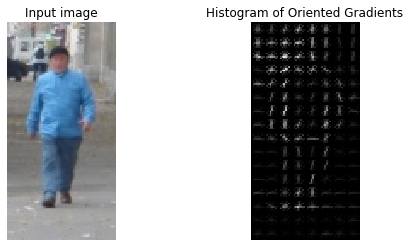

In [10]:
from skimage.feature import hog
from skimage import data, exposure


image = cv2.imread("Datasets\\Test\\Pos\\crop001512a.jpg")

hog_vec, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 255))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

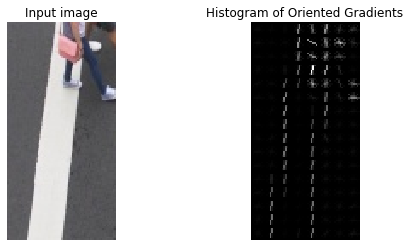

In [5]:
from skimage.feature import hog
from skimage import data, exposure


img2 = cv2.imread("Pedestrians\\ScreenShotVideoResized.jpg")

image = img2[112:240, 120:184]

hog_vec, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 255))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()